# Analysis of the coding mutations

**Goal:** further analysis on the cleaned dataset `cleaned_IMPACT_mutations_180508.txt`, enriched with the annotations from the `add_features()` function obtained at the end of `annotate_cleaned_dataset.ipynb`. The `synonymous_SNV` are excluded from this study, which only focus on the coding mutations.  
This notebook is divided in two parts:
* **1. The `class` feature: somatic vs non-somatic**: introduce a new feature to class the coding mutations as somatic or non-somatic, and compare these two classes (frequency_in_normals, vaf, strand bias, Kaviar_AF, cosmic count).  
* **2. The `mut_key` feature: study of reccurent mutations**: study the reccurence of coding mutations and the inconsistent `class` classification.

**Refs:**
* [CodingDistributions.Rmd [Elsa]](
https://github.com/ElsaB/impact-annotator/blob/master/analysis/description/180510_elsa/CodingDistributions.Rmd)

***

In [1]:
source("../../../src/utils/custom_tools.R")
setup_environment("../../../src/utils")

In [2]:
impact <- read.table("../../../data/cleaned_IMPACT_mutations_180508.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)
impact <- add_features("../../../data/", impact, annotations = TRUE)

The `synonymous_SNV` are excluded from this study, which focus only on the coding mutations.

In [3]:
impact <- impact[impact$Consequence != "synonymous_SNV",] # remove the synonymous mutations

nrow(impact[impact$confidence_class == "UNKNOWN",])
impact <- impact[impact$confidence_class != "UNKNOWN",] # keep only the curated mutation (remove 29 rows)

nrow(impact)

[1] 29

[1] 198259

## The `class` feature: somatic vs non-somatic

### Creating the feature

We create a new feature `class`:
* A mutation has `class = somatic` if `confidence_class = AUTO_OK | MANUAL_OK`
* A mutation has `class = non-somatic` if `confidence_class = UNLIKELY | OK_NOT_SO` (it is either a germline or an artefact)

In [4]:
impact$class <- "non-somatic"
impact$class[impact$confidence_class == "AUTO_OK" | impact$confidence_class == "MANUAL_OK"] <- "somatic"
addmargins(table(impact$class, impact$confidence_class), margin = 2)
100 * nrow(impact[impact$class == "non-somatic",]) / nrow(impact) # percentage of non-somatic mutations

AUTO_OK MANUAL_OK OK_NOT_SO UNLIKELY Sum   
  non-somatic      0     0      345       10846     11191
  somatic     180733  6335        0           0    187068

[1] 5.644637

The dataset is highly unbalanced with 11,213 non-somatic mutations ($5.7\%$ of the samples) vs 187,098 somatic mutations ($94.3\%$ of the samples).

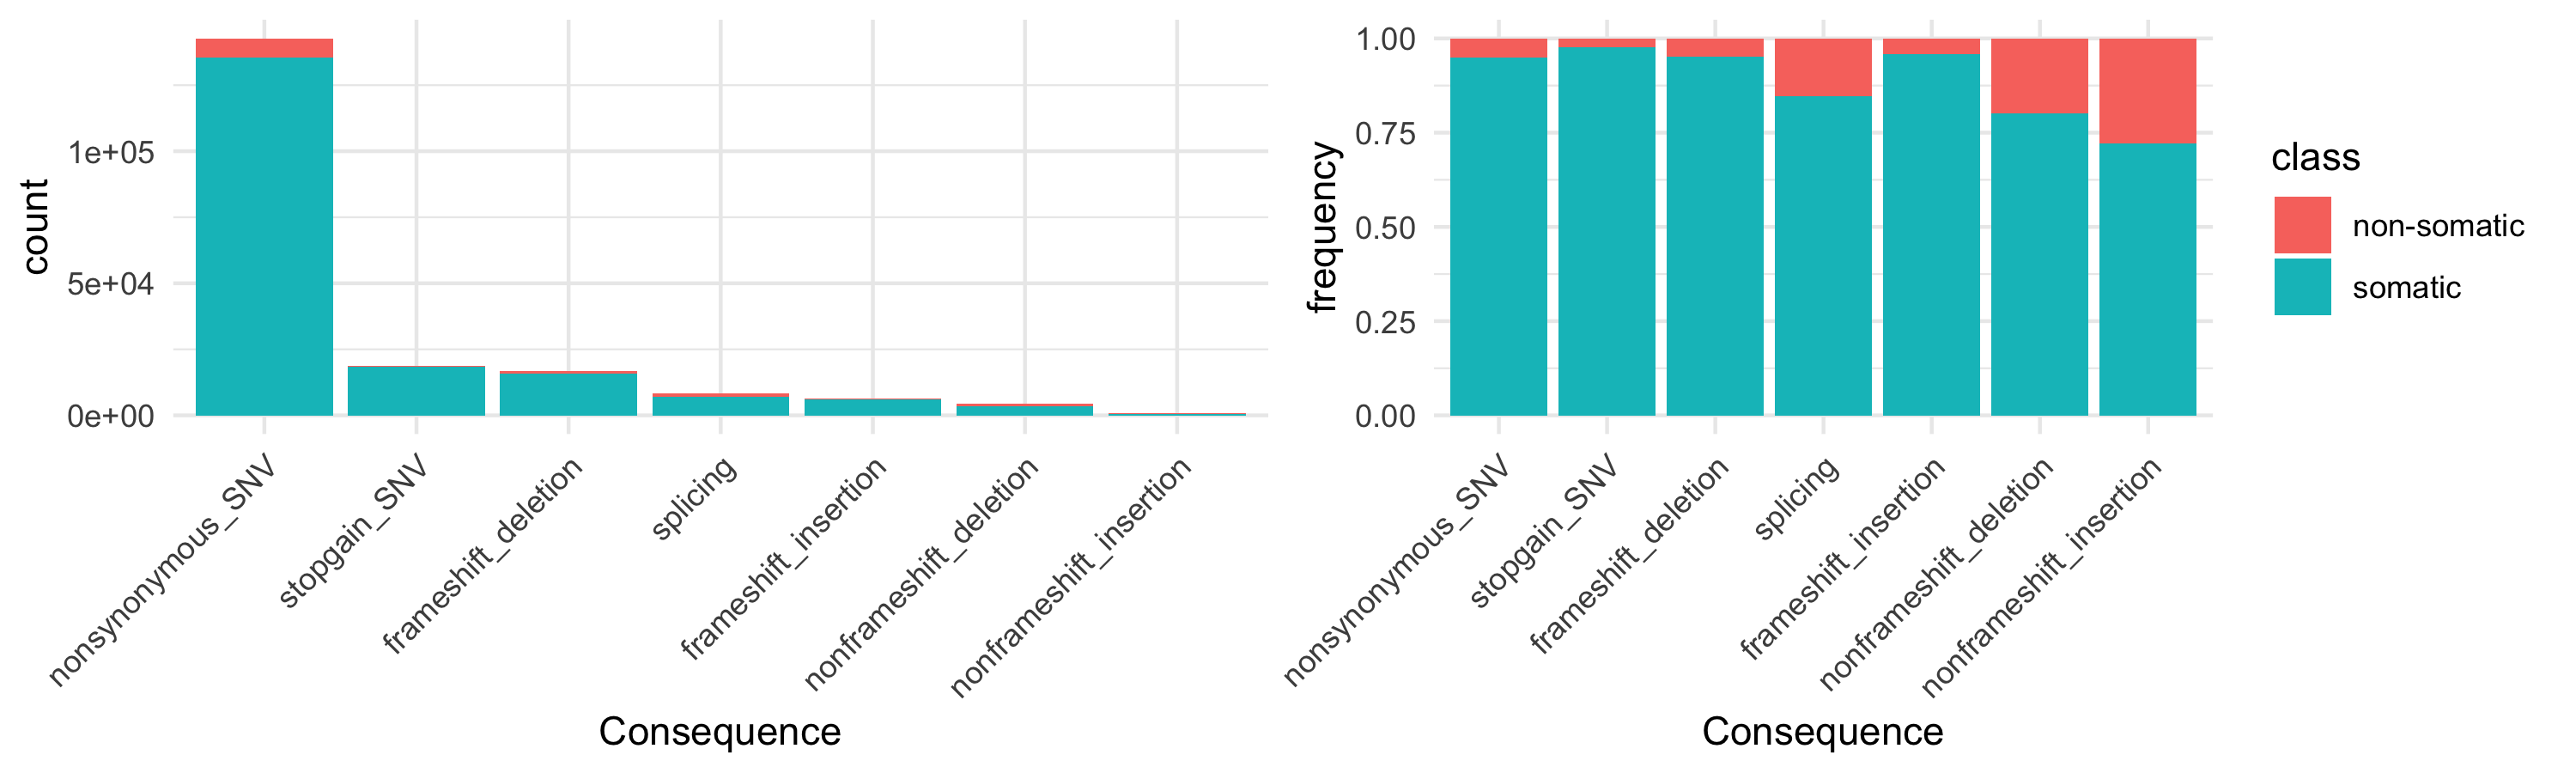

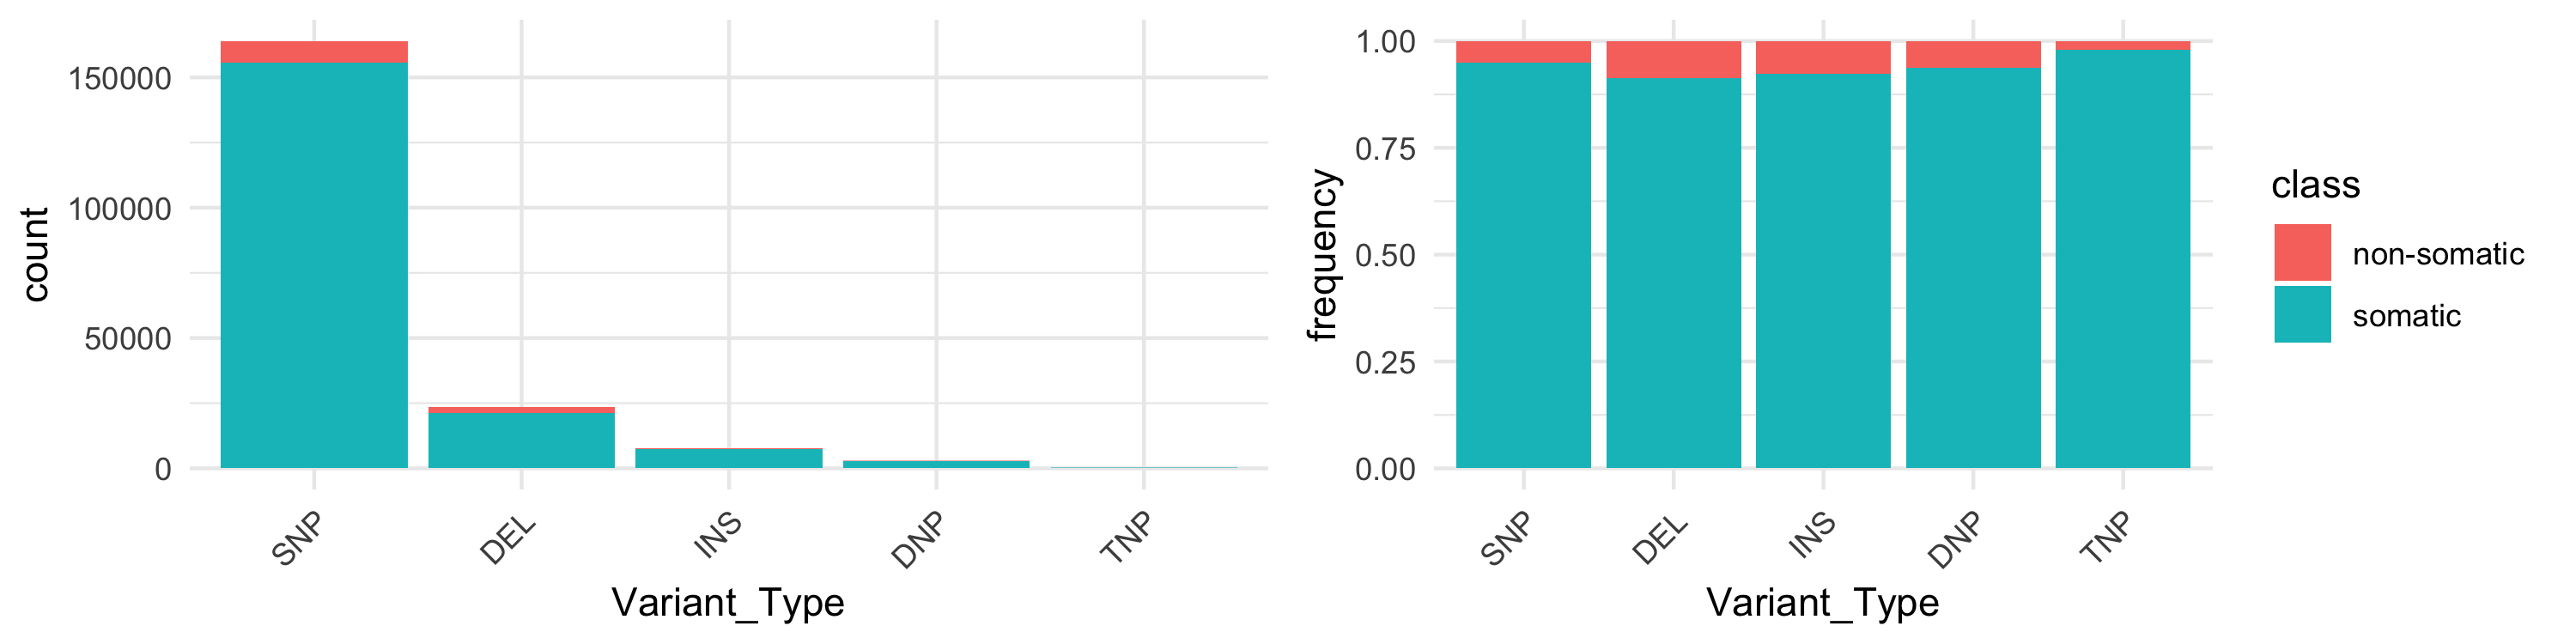

In [5]:
plot_contingency_table_as_histograms(impact, "Consequence", "class")
plot_contingency_table_as_histograms(impact, "Variant_Type", "class", 10, 2.5)

Nothing particularly interesting was found here, it does not seem the mutation `Consequence` or `Variant_Type` features have a clear impact on the `class` of the mutation. We can notice the relatively high amount of `non-somatic` in the `nonframeshift_deletion` and `nonframeshift_insertion` mutations.

### Comparison of the `frequency_in_normals`

Distribution of `frequency_in_normals` for the somatic vs non-somatic `class` (warning this plot concerns only the non-null `frequency_in_normals` ie 2.03% of the data):

[1] "4023 over 198259 (2.03%)"

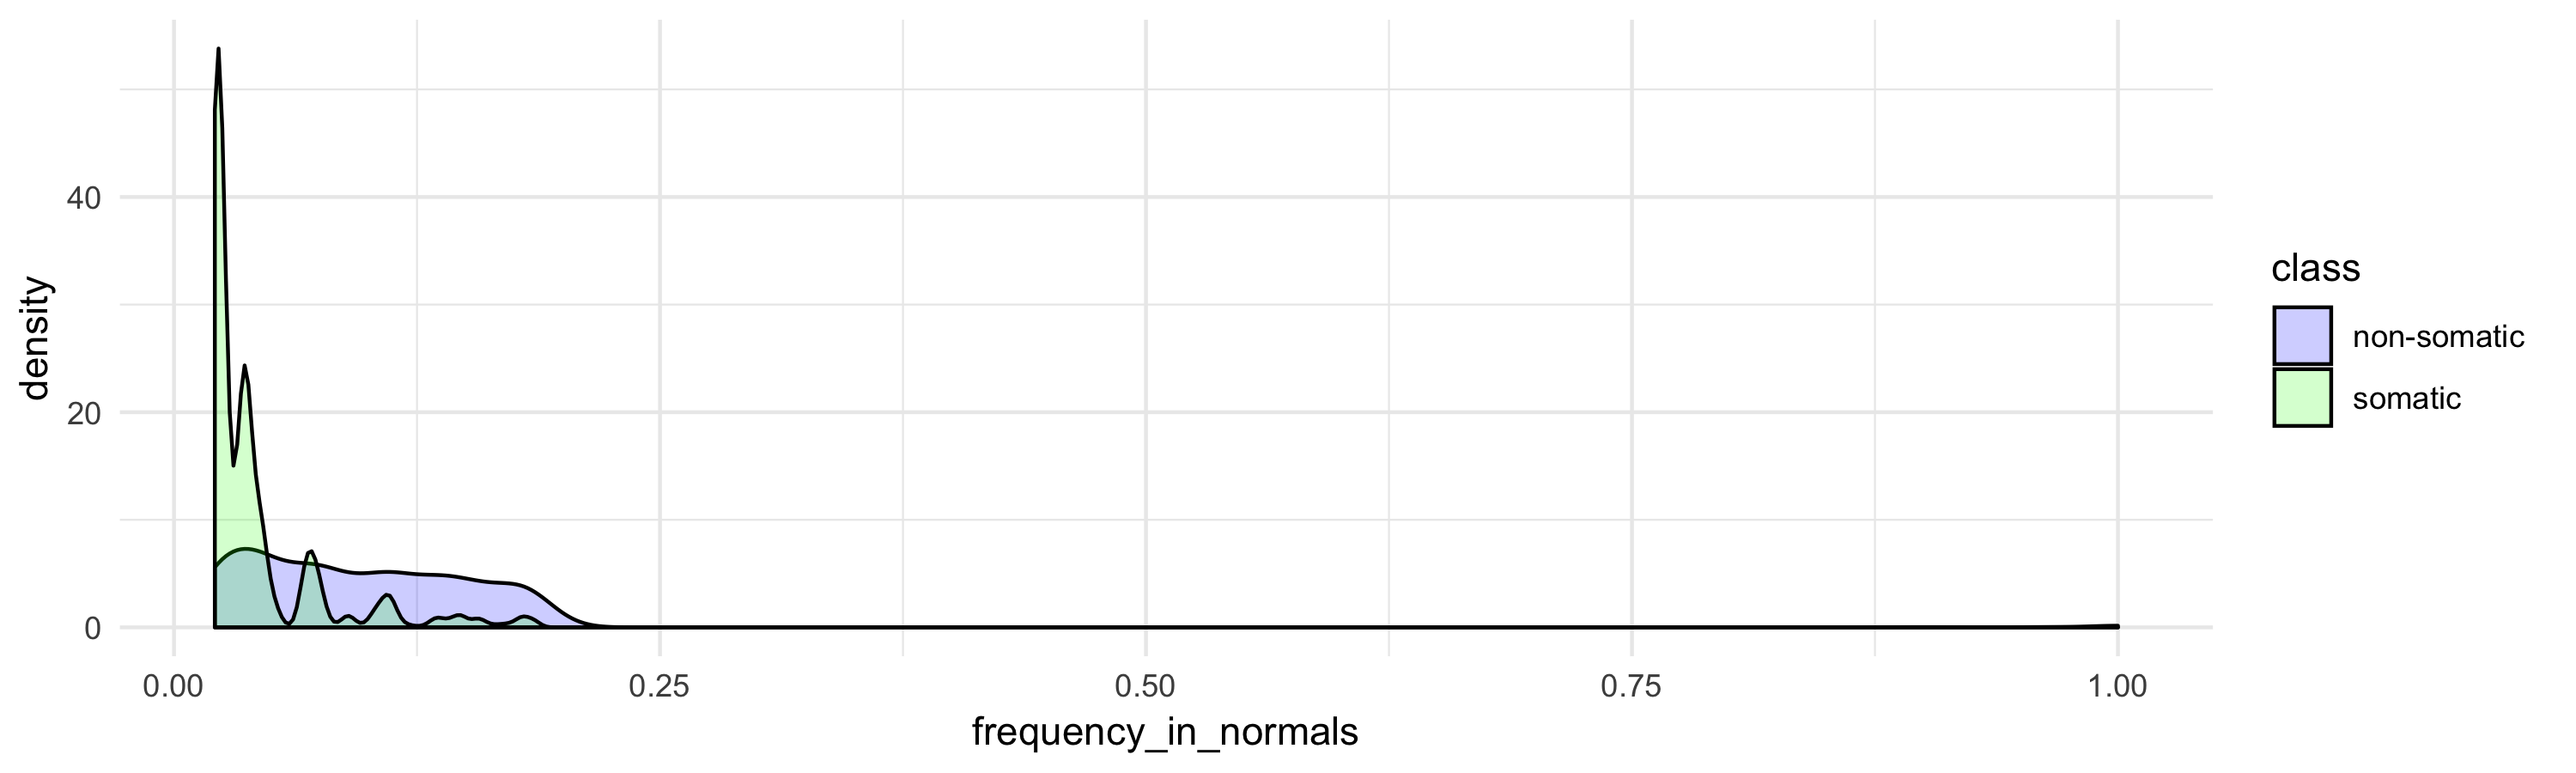

In [6]:
print_count_and_proportion(nrow(impact[impact$frequency_in_normals != 0,]), nrow(impact))
plot_density(impact[impact$frequency_in_normals != 0,], "frequency_in_normals", "class")

Overall the non-somatic mutations are, as expected, more present in normals (due to the germline part). However there are some somatic mutations with a not-so-close-to-0 `frequency_in_normals`:

[1] 2051

[1] 173

[1] 0

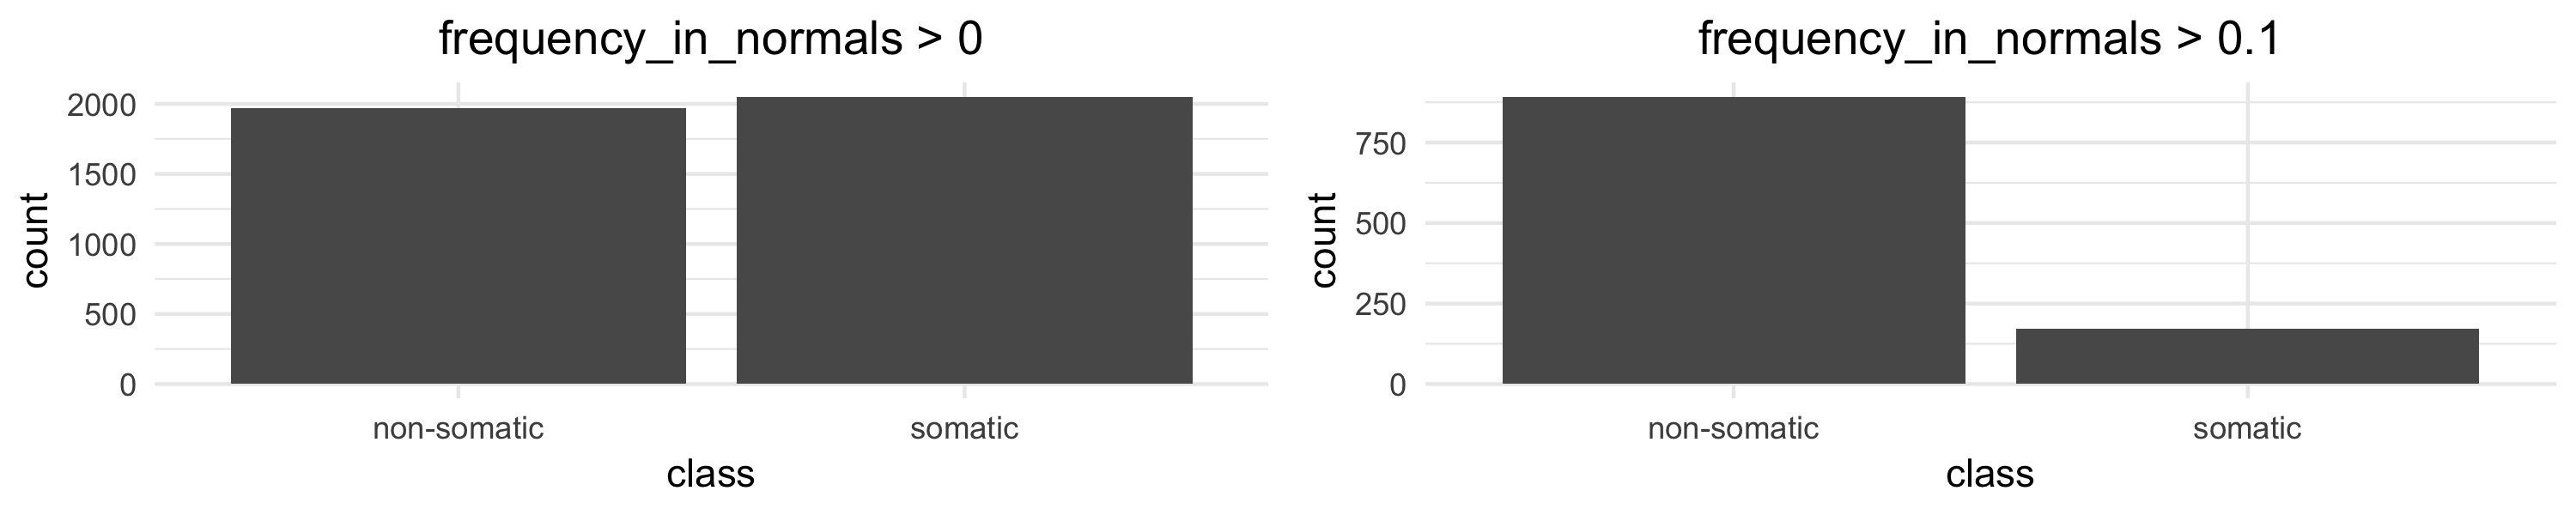

In [7]:
nrow(impact[impact$frequency_in_normals > 0   & impact$class == "somatic",])
nrow(impact[impact$frequency_in_normals > 0.1 & impact$class == "somatic",])
nrow(impact[impact$frequency_in_normals > 0.2 & impact$class == "somatic",])

notebook_plot_size(6, 2)
plot1 <- ggplot(impact[impact$frequency_in_normals > 0  ,]) + geom_bar(aes(class)) + ggtitle("frequency_in_normals > 0"  ) + theme(plot.title = element_text(hjust = 0.5))
plot2 <- ggplot(impact[impact$frequency_in_normals > 0.1,]) + geom_bar(aes(class)) + ggtitle("frequency_in_normals > 0.1") + theme(plot.title = element_text(hjust = 0.5))
plot_side_by_side(plot1, plot2)

[1] "Number of different genes:  73"


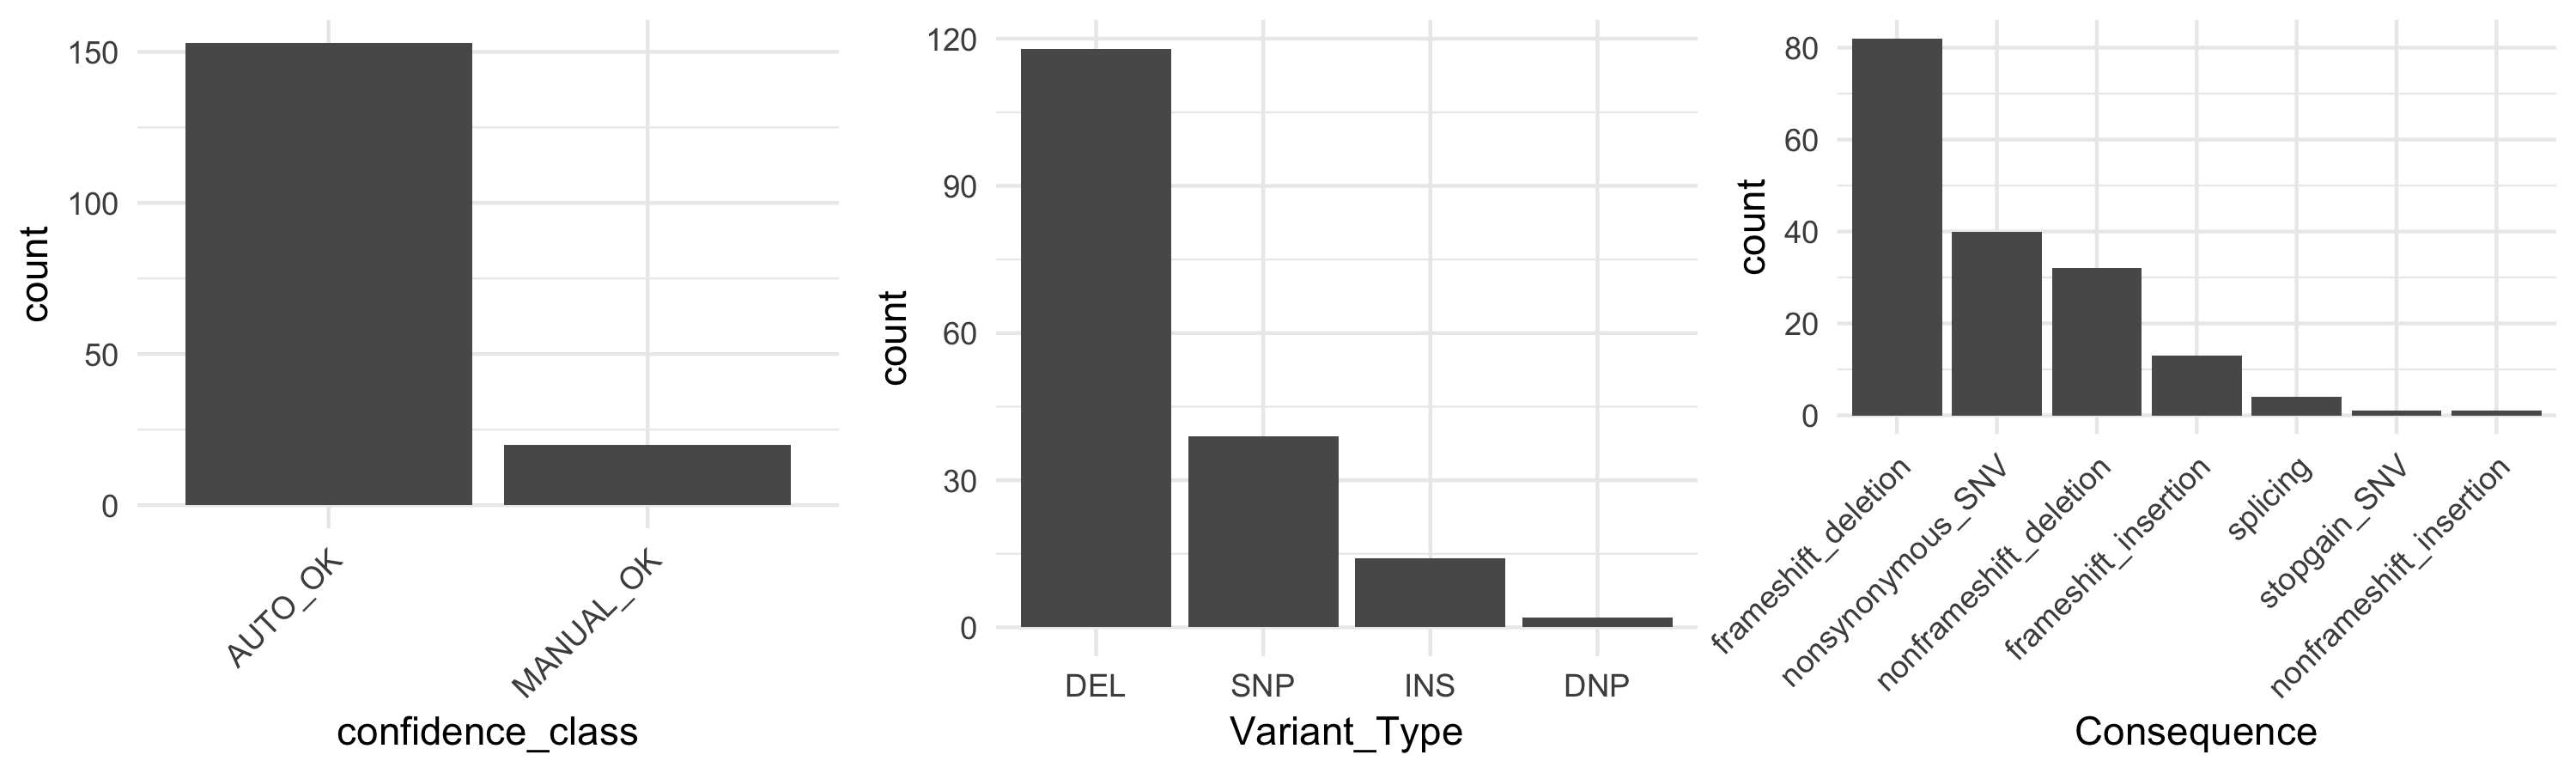

In [8]:
get_possible_correlations(impact[impact$frequency_in_normals > 0.1 & impact$class == "somatic",])

[1] "Number of different genes:  379"


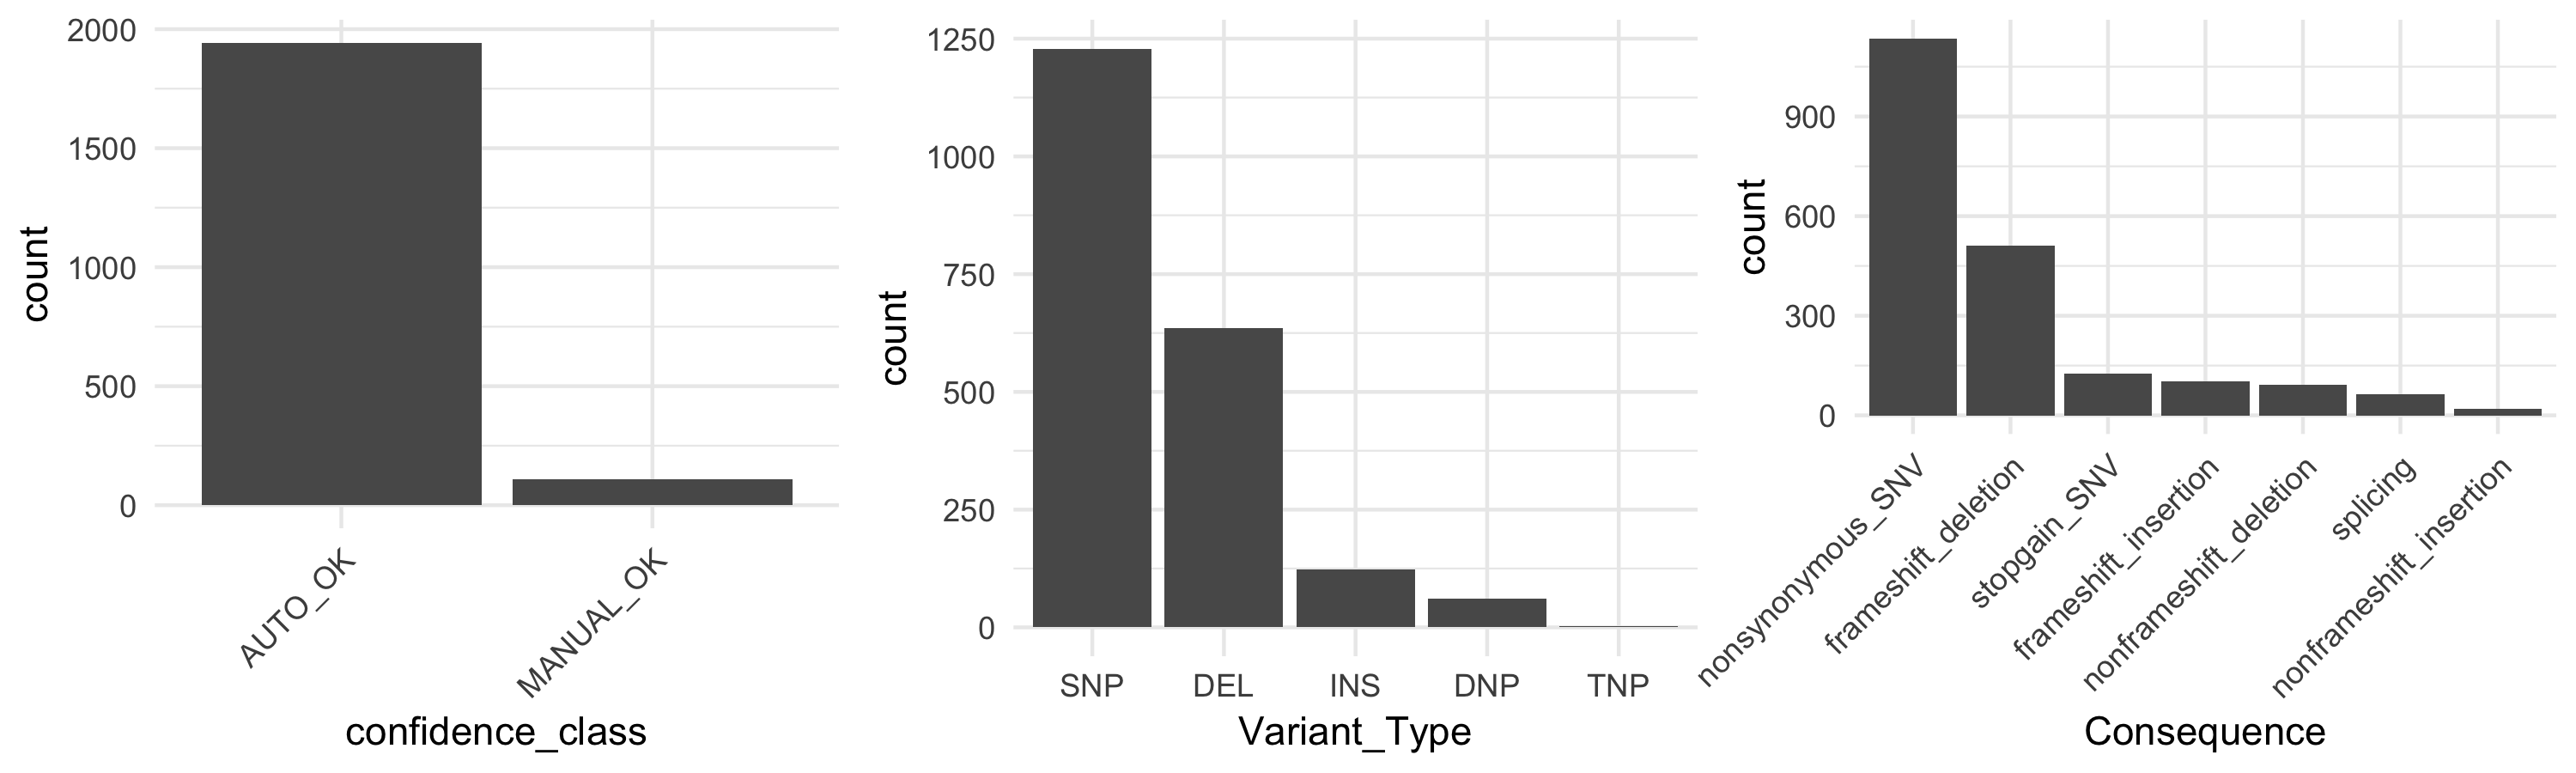

In [9]:
get_possible_correlations(impact[impact$frequency_in_normals > 0 & impact$class == "somatic",])

### Comparison of the `t_vaf`

Distribution of `t_vaf` for the somatic vs non-somatic `class`:

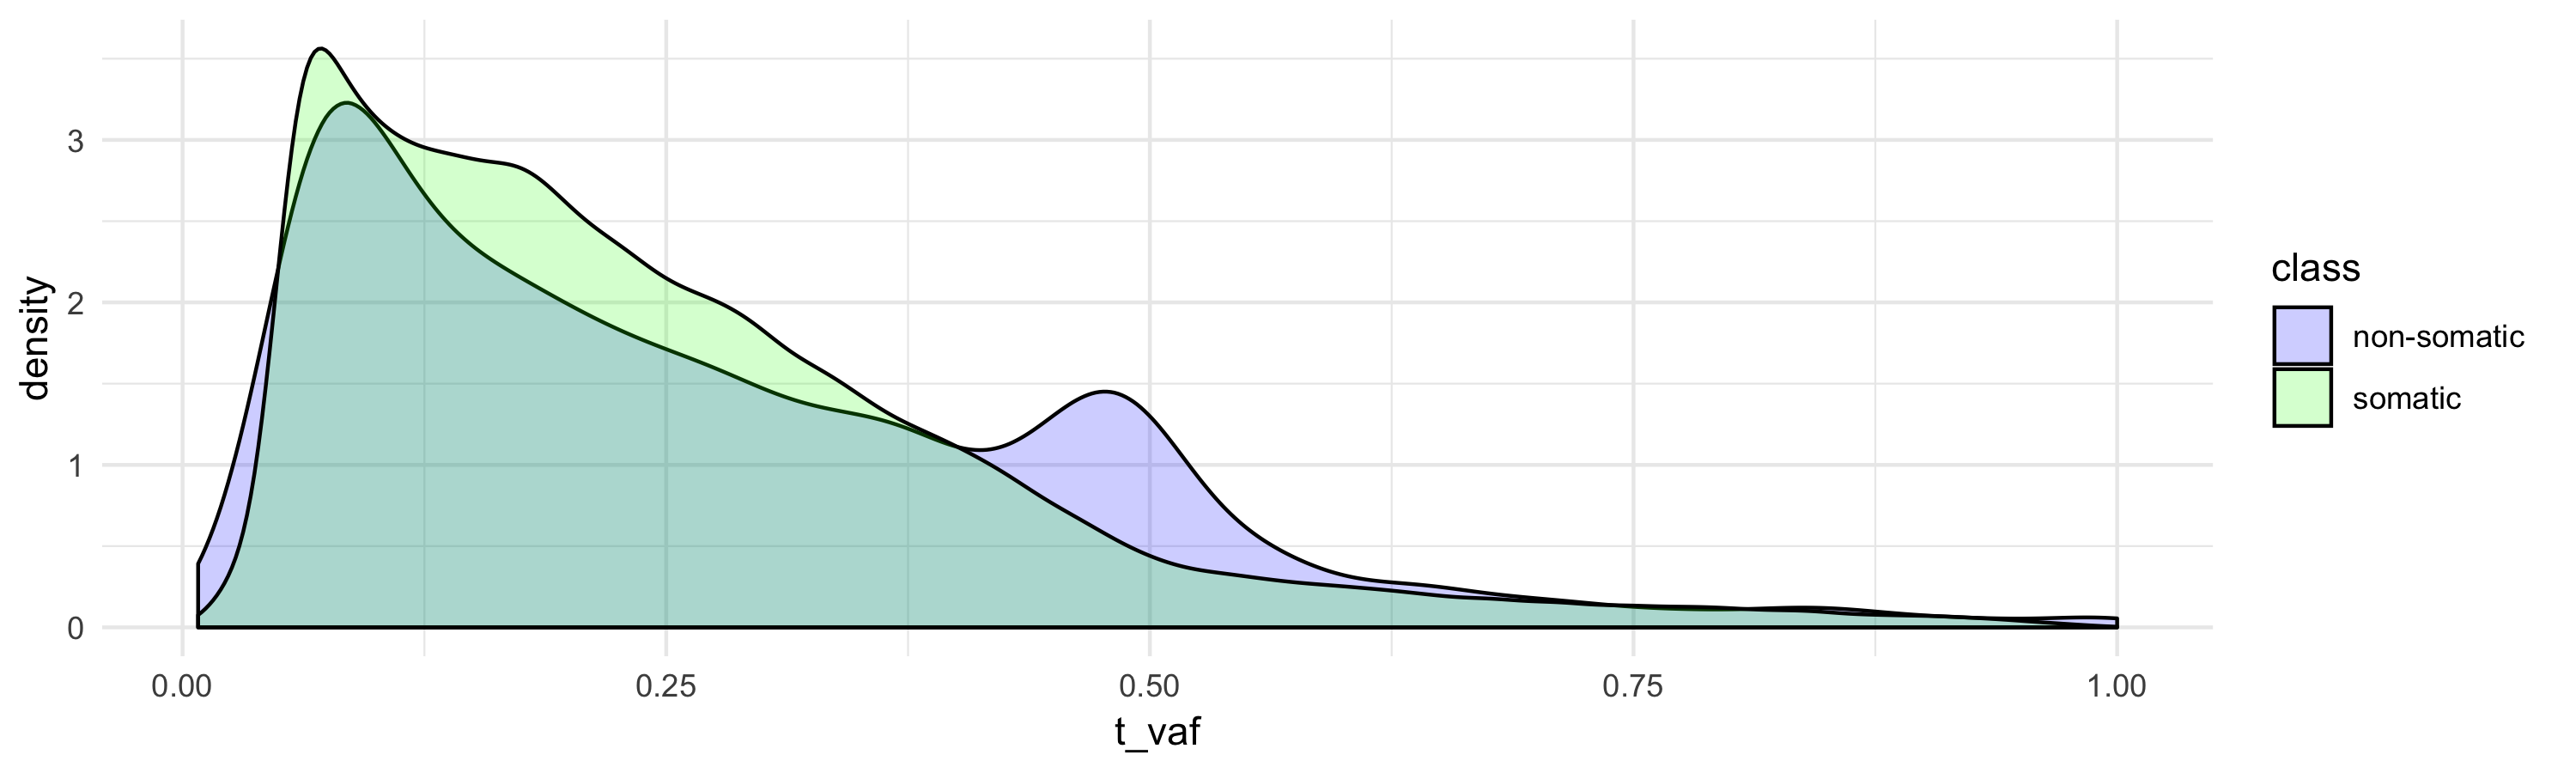

In [10]:
plot_density(impact, "t_vaf", "class")

From `CodingDistributions.Rmd [Elsa]`: "As expected, the non-somatic density has a peak at 0.5 (ie the likely germline calls), and a peak at low VAF (ie the likely artefacts calls)."

### Comparison of the strand bias

We evaluate the `strand_ratio` for each mutation as:
$$\text{strand_ratio}\ =\ \frac{\min(\text{t_alt_neg_count}, \text{t_alt_plus_count})}
                              {\max(\text{t_alt_neg_count}, \text{t_alt_plus_count})}$$
                              
e.g. the lowest count over the maximum count, thus giving a result between 0 and 1 (1 being a low strand bias, because the count for the neg and pos are the same).

In [11]:
impact$strand_ratio <- pmin(impact$t_alt_neg_count, impact$t_alt_plus_count) /
                       pmax(impact$t_alt_neg_count, impact$t_alt_plus_count)

Distribution of `strand_ratio` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale):

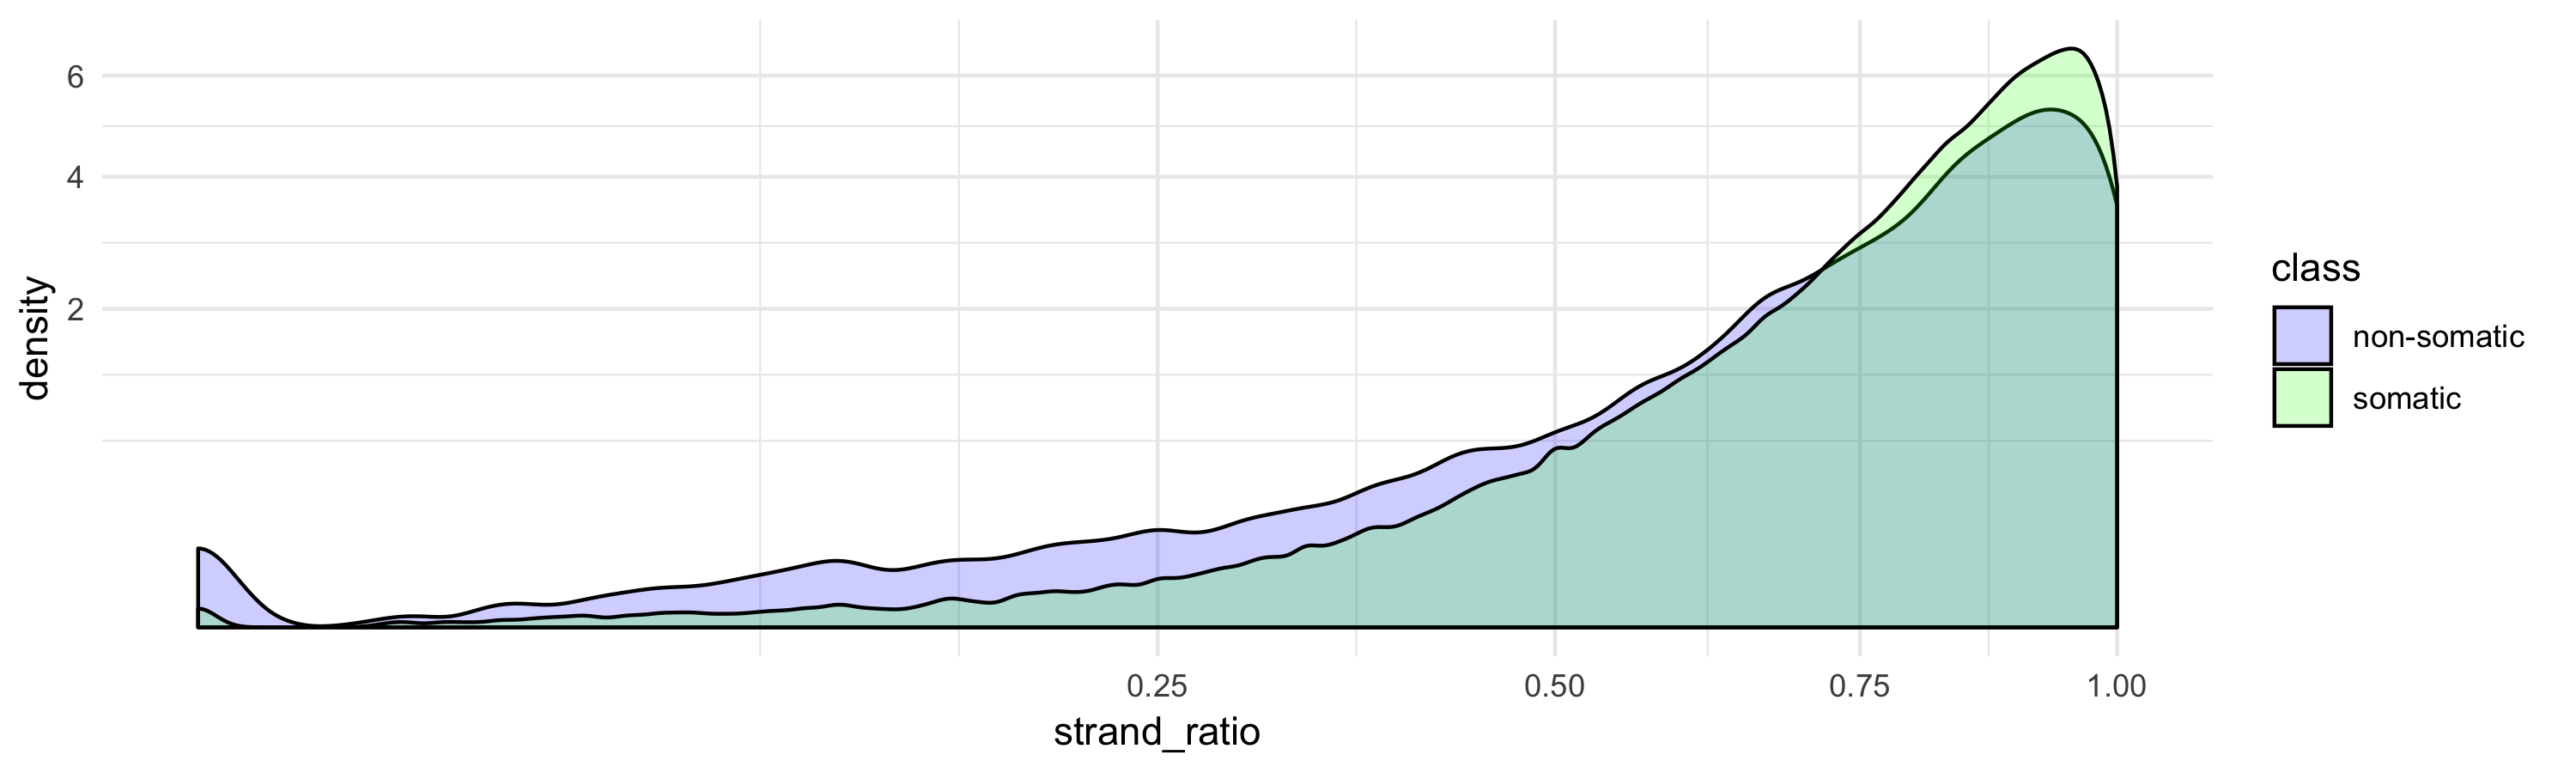

In [12]:
plot_density(impact, "strand_ratio", "class") + scale_x_sqrt() + scale_y_sqrt()

From `CodingDistributions.Rmd [Elsa]`: "As expected, the non-somatic density has a heavier low strand ratio tail (likely from the artefact calls), although this is not very pronounced."

### `strand_ratio` vs `t_vaf`

Below is an attempt to plot the `strand_ratio` vs the `t_vaf` to separate the germline (`t_vaf` $\approx 0.5$ and high `strand_ratio`) from the artefact (low `t_vaf` and low `strand_ratio`):

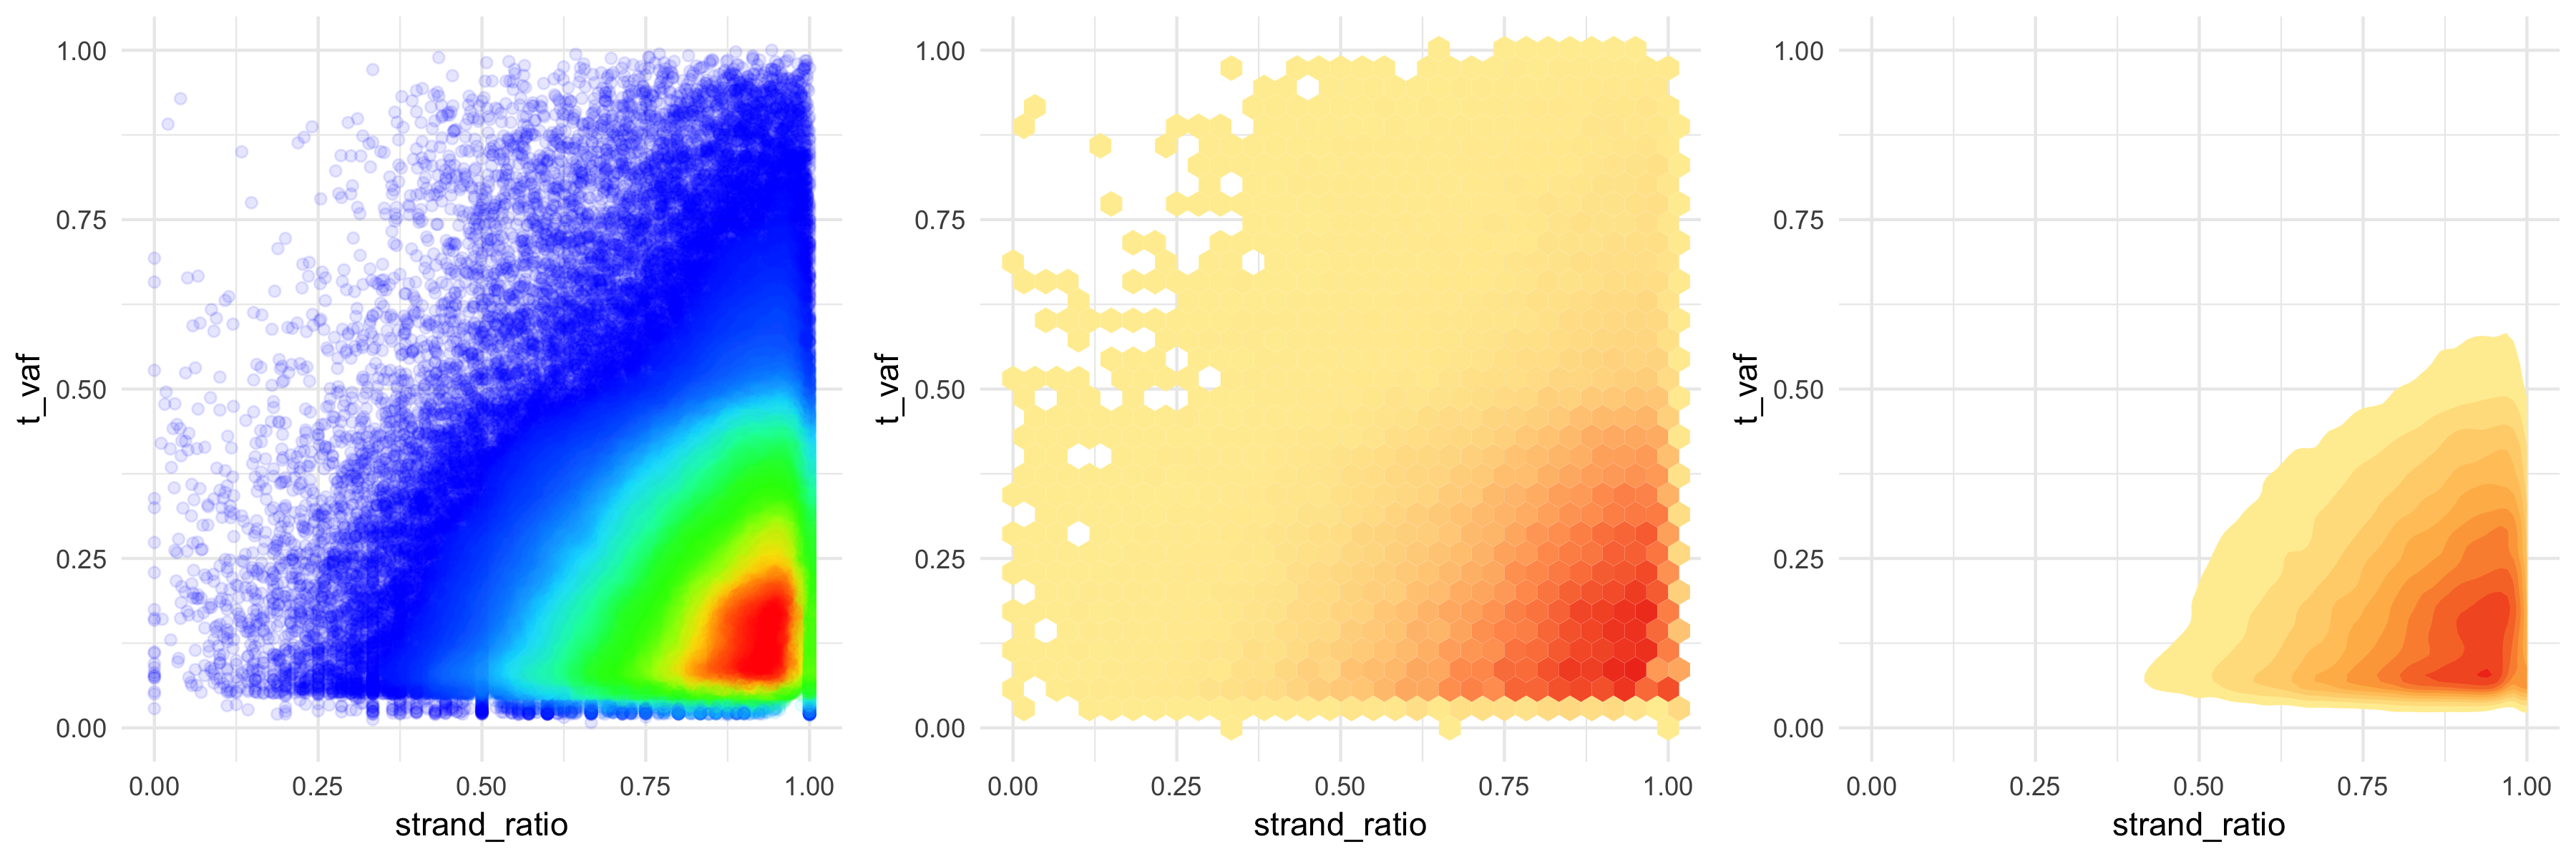

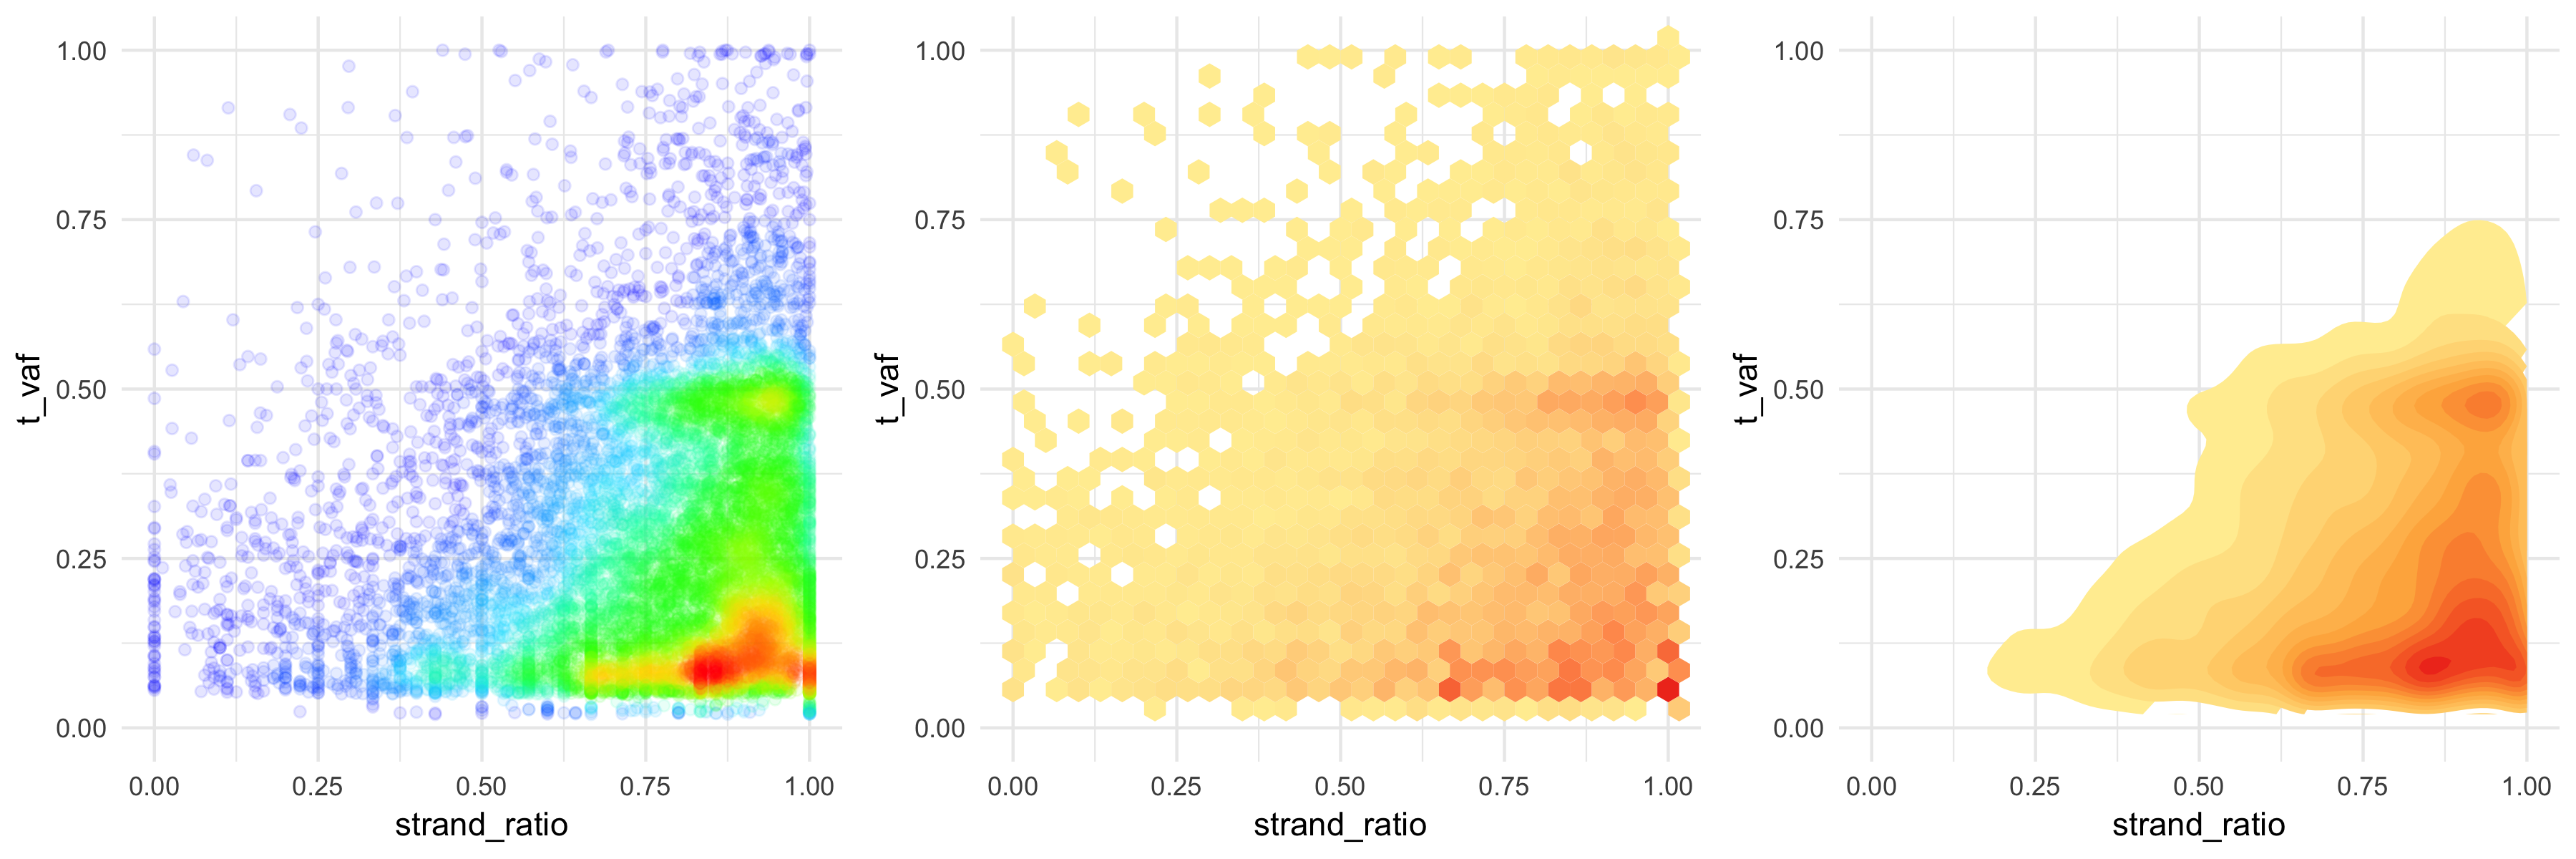

In [13]:
plot_density_2d(impact[impact$class == "somatic",], "strand_ratio", "t_vaf",
                to_add = coord_cartesian(xlim = c(0,1), ylim = c(0,1)))
plot_density_2d(impact[impact$class == "non-somatic",], "strand_ratio", "t_vaf",
                to_add = coord_cartesian(xlim = c(0,1), ylim = c(0,1)))

We clearly see the domain of the germline with a peak at `t_vaf = 0.5` in the lower graphs.

### Comparison of `Kaviar_AF`

Distribution of `Kaviar_AF` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale and this plot concerns only the non-null `Kaviar_AF` ie 25.84% of the data):

[1] "198259 over 198259 (100.00%)"

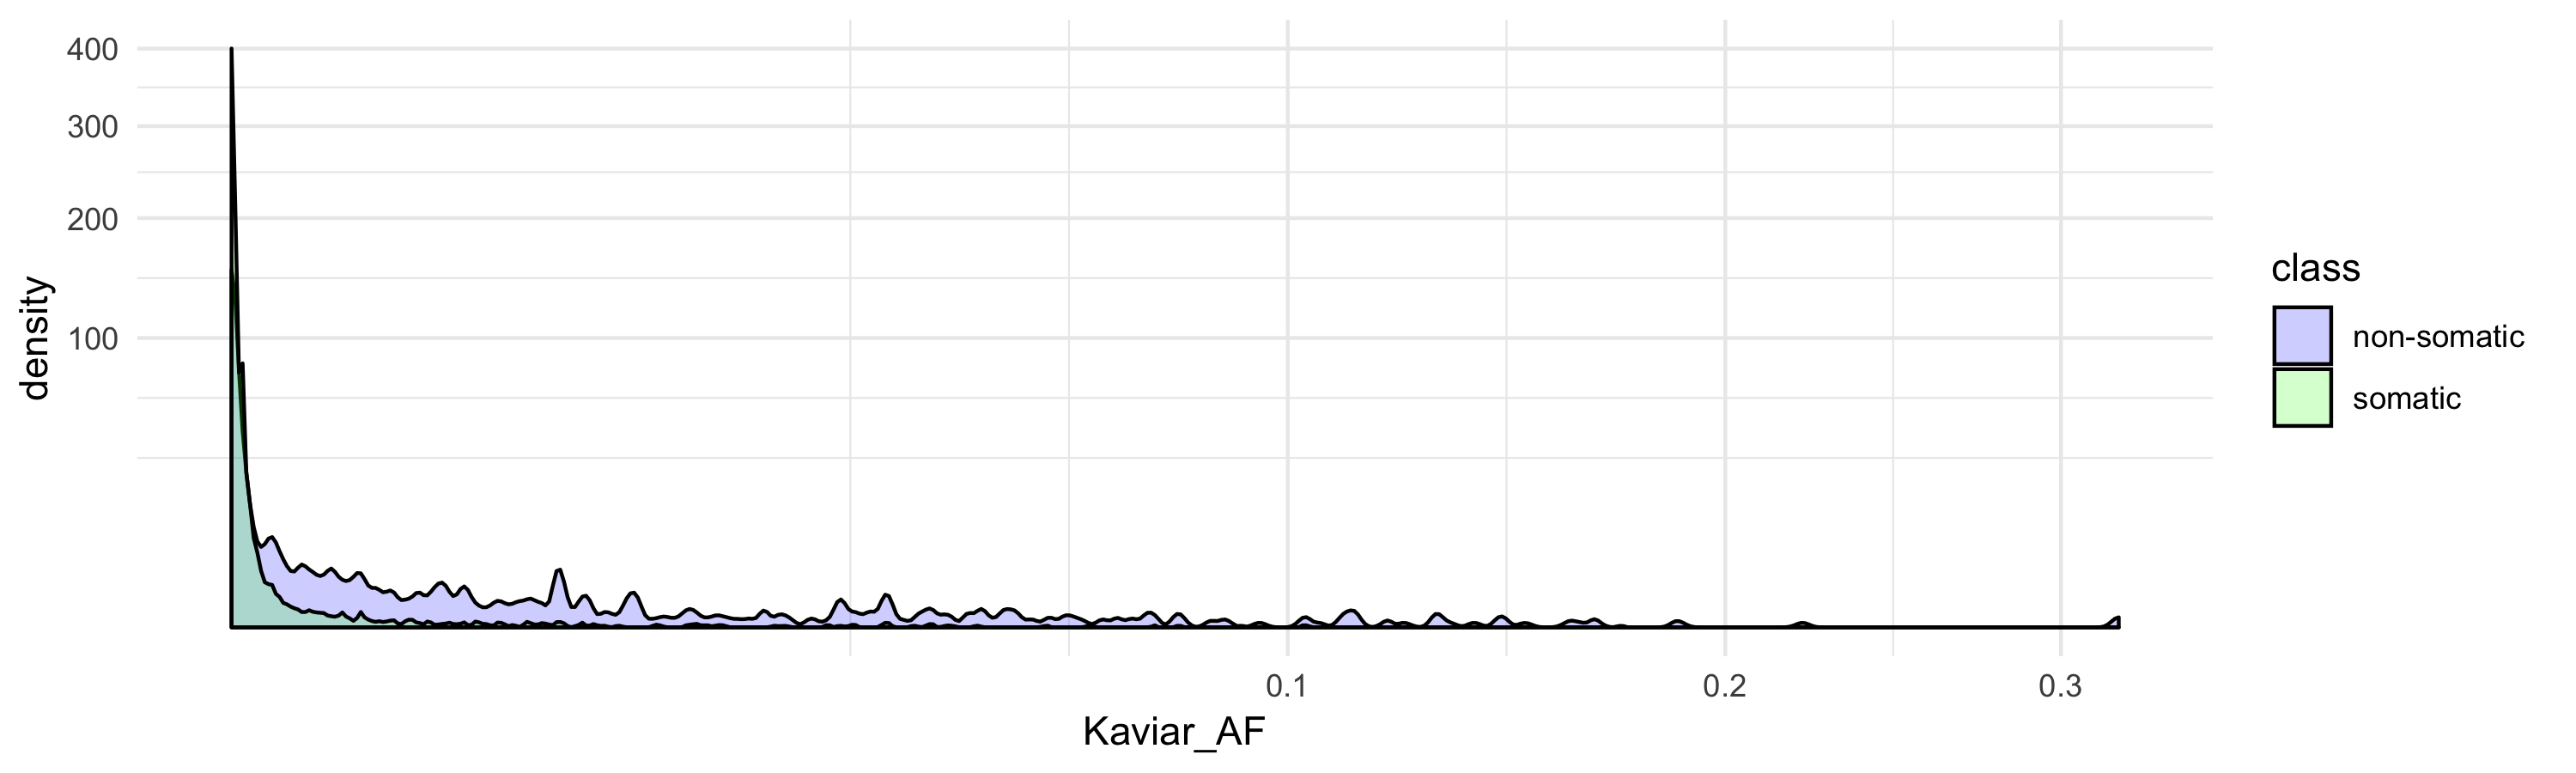

In [14]:
print_count_and_proportion(nrow(impact), nrow(impact))
plot_density(impact, "Kaviar_AF", "class") + scale_x_sqrt() + scale_y_sqrt()

What was expected appears clearly, the `non-somatic` class presents a way longer tail on the higher `Kaviar_AF` value (due to the germline calls).

In [15]:
summary(impact$Kaviar_AF[impact$class == "somatic"])
summary(impact$Kaviar_AF[impact$class == "non-somatic"])

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 0.000e+00 0.000e+00 2.594e-05 0.000e+00 1.730e-01 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000000 0.0028303 0.0001423 0.3192330 

### Comparison of `cosmic_count`

In [16]:
summary(impact$cosmic_count[impact$class == "somatic"])
summary(impact$cosmic_count[impact$class == "non-somatic"])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     0.0   223.1     1.0 20034.0 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     0.00     0.00    77.86     0.00 33328.00 

Distribution of `cosmic_count` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale and this plot concerns only the non-null `cosmic_count` ie 25.20% of the data):

[1] "49982 over 198259 (25.21%)"

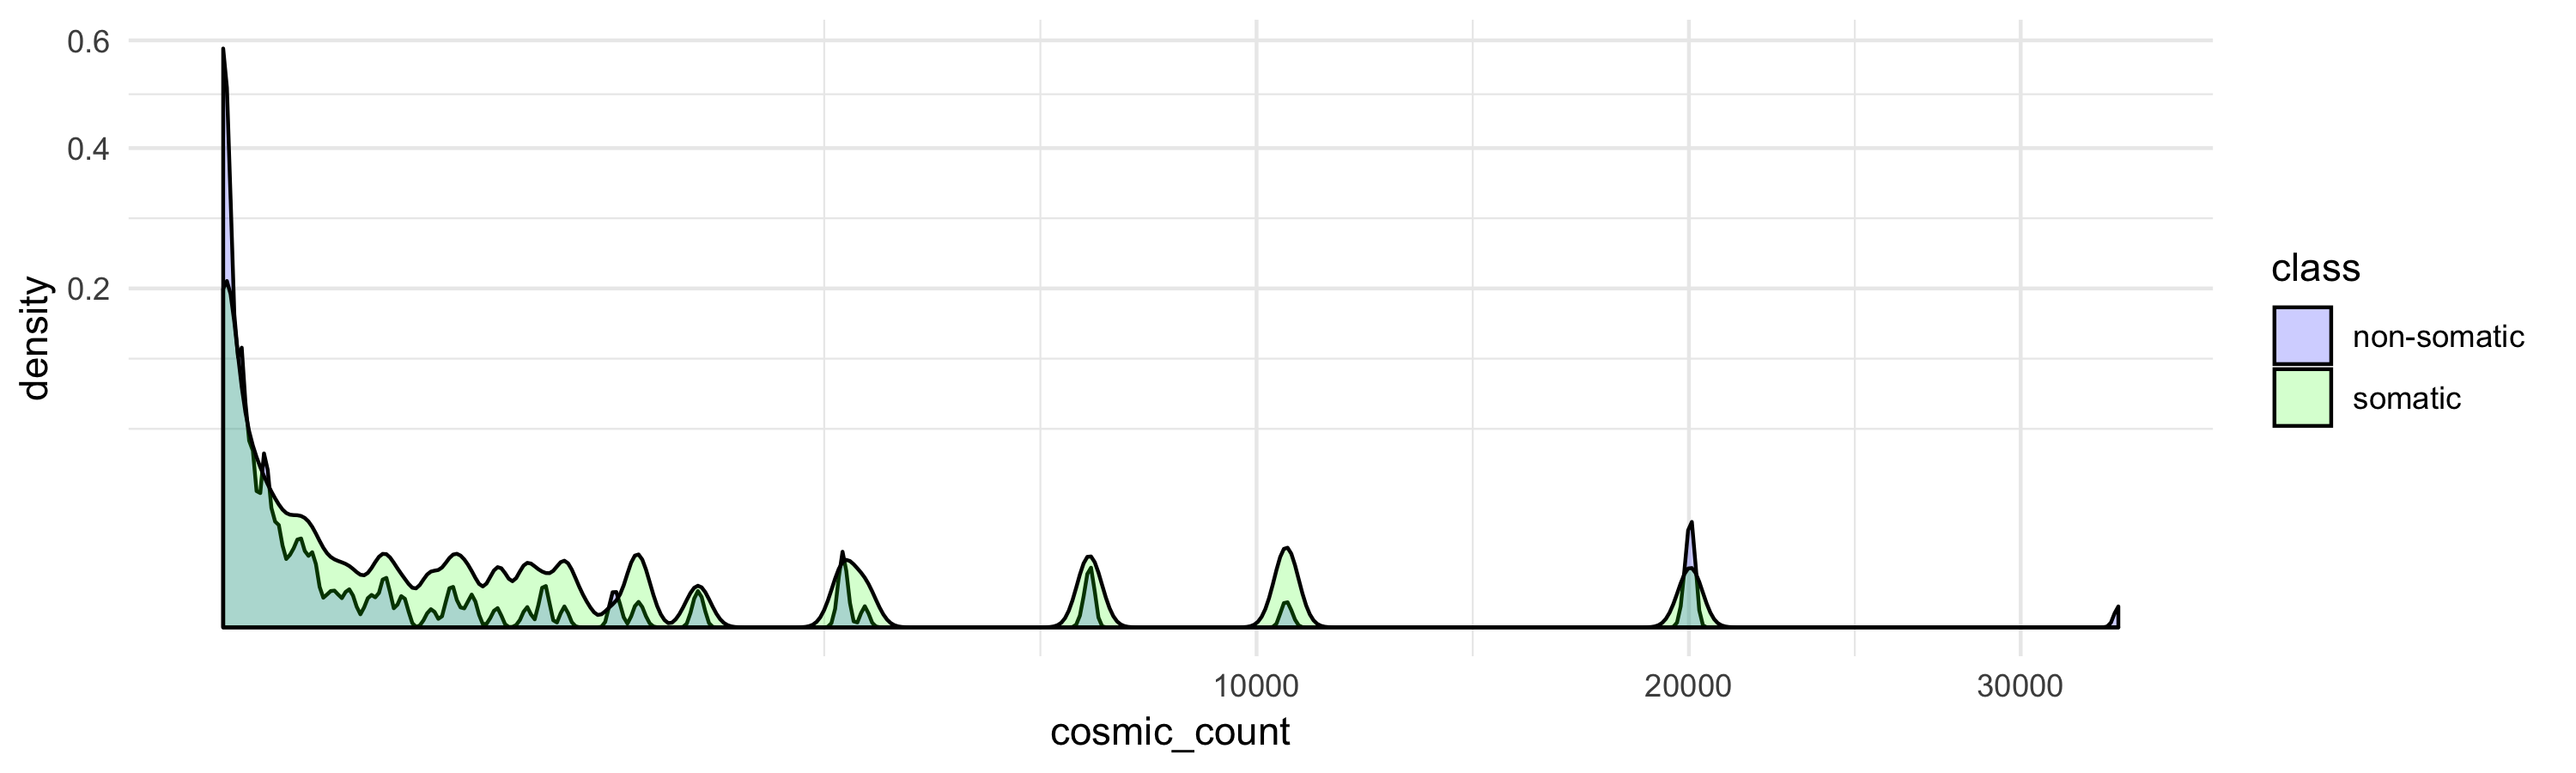

In [17]:
print_count_and_proportion(nrow(impact[impact$cosmic_count != 0,]), nrow(impact))
plot_density(impact[impact$cosmic_count != 0,], "cosmic_count", "class") + scale_x_sqrt() + scale_y_sqrt()

We observe here that the mutations with a high `cosmic_count` are mostly classified as somatic, even if some have been curated as non_somatic.

In [18]:
impact %>% filter(cosmic_count >= 1000) %>%
           group_by(mut_key) %>%
           summarise(cosmic_count  = unique(cosmic_count),
                     Hugo_Symbol   = unique(Hugo_Symbol),
                     HGVSp_Short   = unique(HGVSp_Short),
                     Consequence   = unique(Consequence),
                     n_somatic     = sum(class == "somatic"),
                     n_non_somatic = sum(class == "non-somatic")) %>%
           arrange(-cosmic_count)

mut_key         cosmic_count Hugo_Symbol HGVSp_Short Consequence      
1  9_5073770_G_T   33328        JAK2        p.V617F     nonsynonymous_SNV
2  7_140453136_A_T 20034        BRAF        p.V600E     nonsynonymous_SNV
3  12_25398284_C_T 10579        KRAS        p.G12D      nonsynonymous_SNV
4  12_25398284_C_A  7055        KRAS        p.G12V      nonsynonymous_SNV
5  12_25398281_C_T  3901        KRAS        p.G13D      nonsynonymous_SNV
6  2_209113112_C_T  3761        IDH1        p.R132H     nonsynonymous_SNV
7  12_25398285_C_A  3645        KRAS        p.G12C      nonsynonymous_SNV
8  7_55259515_T_G   2162        EGFR        p.L858R     nonsynonymous_SNV
9  12_25398284_C_G  1677        KRAS        p.G12A      nonsynonymous_SNV
10 3_178952085_A_G  1651        PIK3CA      p.H1047R    nonsynonymous_SNV
11 12_25398285_C_T  1484        KRAS        p.G12S      nonsynonymous_SNV
12 4_1803568_C_G    1239        FGFR3       p.S249C     nonsynonymous_SNV
13 3_178936091_G_A  1135        PIK3CA      p.E545K     nonsynonymous_SNV
14 3_38182641_T_C   1082        MYD88       p.L265P     nonsynonymous_SNV
15 12_25398285_C_G  1008        KRAS        p.G12R      nonsynonymous_SNV
16 1_115256529_T_C  1003        NRAS        p.Q61R      nonsynonymous_SNV
   n_somatic n_non_somatic
1     0       1           
2   622      32           
3  1110       2           
4   896      10           
5   287       1           
6   307       0           
7   566      14           
8   305       4           
9   190       1           
10  751       1           
11   79       4           
12  118       0           
13  721       1           
14   27       0           
15  197       5           
16  184       0

## The `mut_key` feature: study of reccurent mutations

Each mutations is identified by a unique key `mut_key` : `Chromosome`_`Start_Position`_`Reference_Allele`_`Tumor_Seq_Allele2`. The mutations sharing the same key are the same.

In [19]:
head(impact$mut_key)
length(unique(impact$mut_key)) # number of different keys e.g. number of different mutations

[1] "17_7577515_T_G"  "1_46521514_G_C"  "3_142178126_C_A" "4_55139732_T_A" 
[5] "4_153249542_C_A" "4_153332775_C_A"

[1] 135012

### Identify the reccurent mutations

We need to study the reccurence of mutations taking care not to consider a mutation as recurrent if it comes frome the same patient. To do so we will group the rows by patient, and select only the distinct mutations for each patient:

In [20]:
# create a patient id (no problem will be caused by 'None-T01-IM6' which will become 'None-T01-')
impact$patient_id <- substr(impact$Tumor_Sample_Barcode, 1, 9)
head(unique(impact$patient_id))

[1] "P-0000012" "P-0000023" "P-0000024" "P-0000025" "P-0000026" "P-0000030"

In [21]:
impact_unique_mut_keys_per_patient <- as.data.frame(impact %>% group_by(patient_id) %>%
                                                               select(patient_id, mut_key, Hugo_Symbol, Consequence, Variant_Type, class) %>%
                                                               filter(! duplicated(mut_key)))
nrow(impact)
nrow(impact_unique_mut_keys_per_patient)

[1] 198259

[1] 190526

In [22]:
mut_key_info <- as.data.frame(impact_unique_mut_keys_per_patient %>% group_by(mut_key) %>%
                                                                     summarise(count = n(), Hugo_Symbol = unique(Hugo_Symbol)))
head(mut_key_info)

mut_key                       count Hugo_Symbol
1 1_108206648_AGAAGTTG_GAAGTTGT 1     ARID1A     
2 1_11167549_A_G                1     MTOR       
3 1_11168271_G_A                1     MTOR       
4 1_11168272_A_G                1     MTOR       
5 1_11168304_G_A                1     MTOR       
6 1_11168316_A_G                1     MTOR

In [23]:
for (threshold in c(2, 3, 5, 10)) {
    
    mut_key_info_threshold <- mut_key_info[mut_key_info$count >= threshold,]
    
    print(sprintf("%2.0f%% (%5d) of the keys are shared by at least %2d samples [%2.0f%% (%5d) of the rows concerned]",
                  100 * nrow(mut_key_info_threshold) / nrow(mut_key_info),
                  nrow(mut_key_info_threshold),
                  threshold,
                  100 * nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,]) / nrow(impact_unique_mut_keys_per_patient),
                  nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,])))
}

[1] "13% (17584) of the keys are shared by at least  2 samples [38% (73098) of the rows concerned]"
[1] " 5% ( 6245) of the keys are shared by at least  3 samples [26% (50420) of the rows concerned]"
[1] " 2% ( 2227) of the keys are shared by at least  5 samples [20% (37230) of the rows concerned]"
[1] " 1% (  855) of the keys are shared by at least 10 samples [15% (28717) of the rows concerned]"


Distribution of the mutations key count for the mutations present in at least 2 samples:

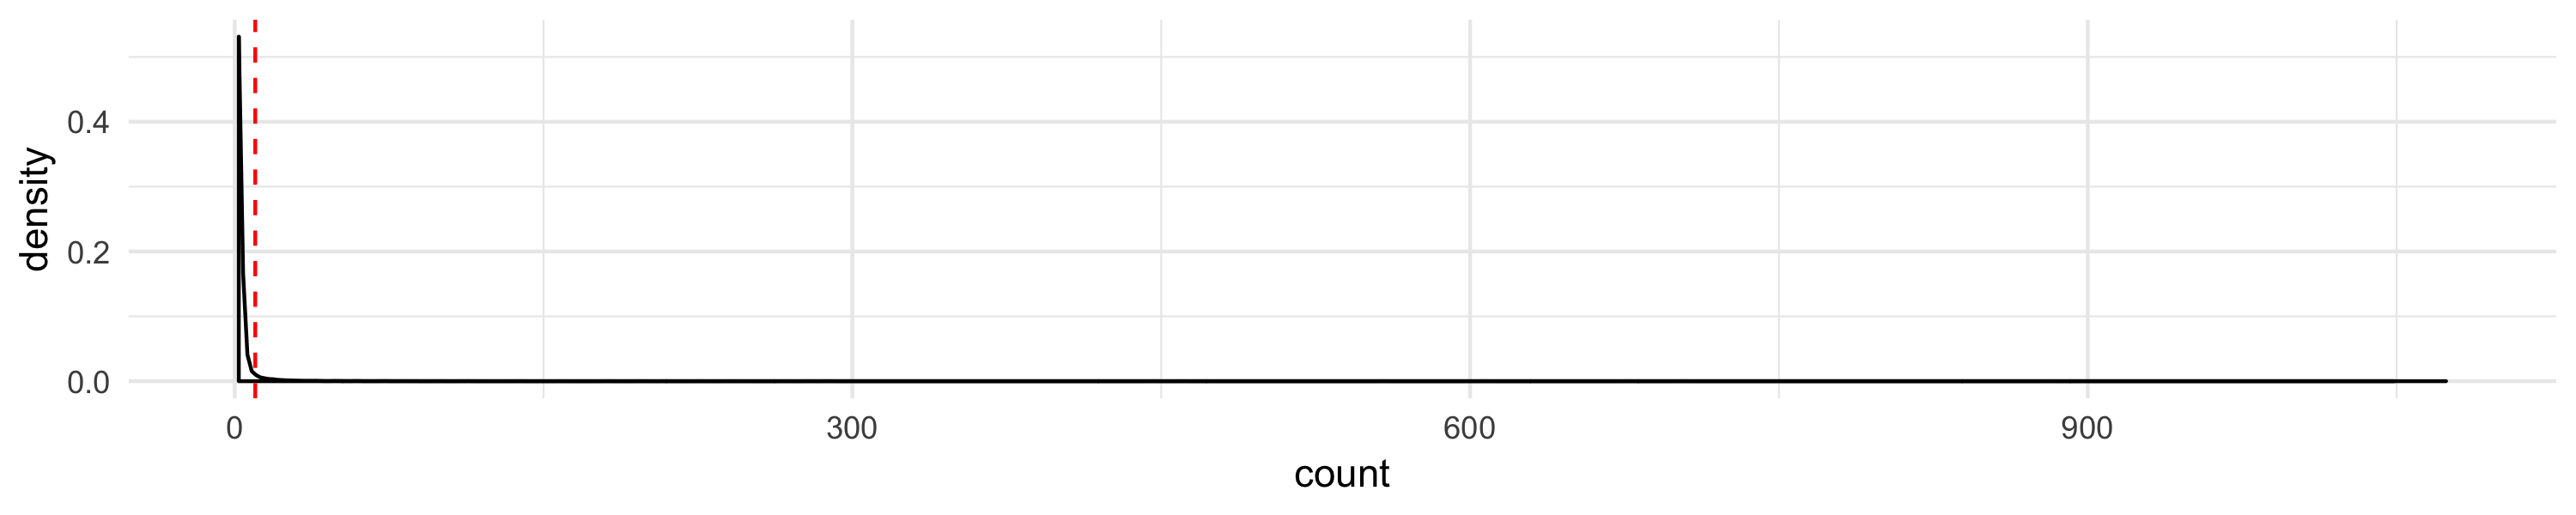

In [24]:
repeated_key <- mut_key_info[mut_key_info$count >= 2,] # keys shared by at least 2 samples
plot_density(repeated_key, "count", adjust = 5, lines = 10, height = 2)

### Sudy the reccurent mutations genes

In [25]:
length(unique(repeated_key$Hugo_Symbol))

[1] 463

In [26]:
head(repeated_key)

mut_key        count Hugo_Symbol
17 1_11169376_A_T 3     MTOR       
18 1_11169377_T_A 3     MTOR       
22 1_11169741_G_A 2     MTOR       
28 1_11174379_C_T 2     MTOR       
30 1_11174386_C_A 3     MTOR       
31 1_11174395_A_C 4     MTOR

Here is a plot of the genes that are the most mutated **accross the mutation keys**:

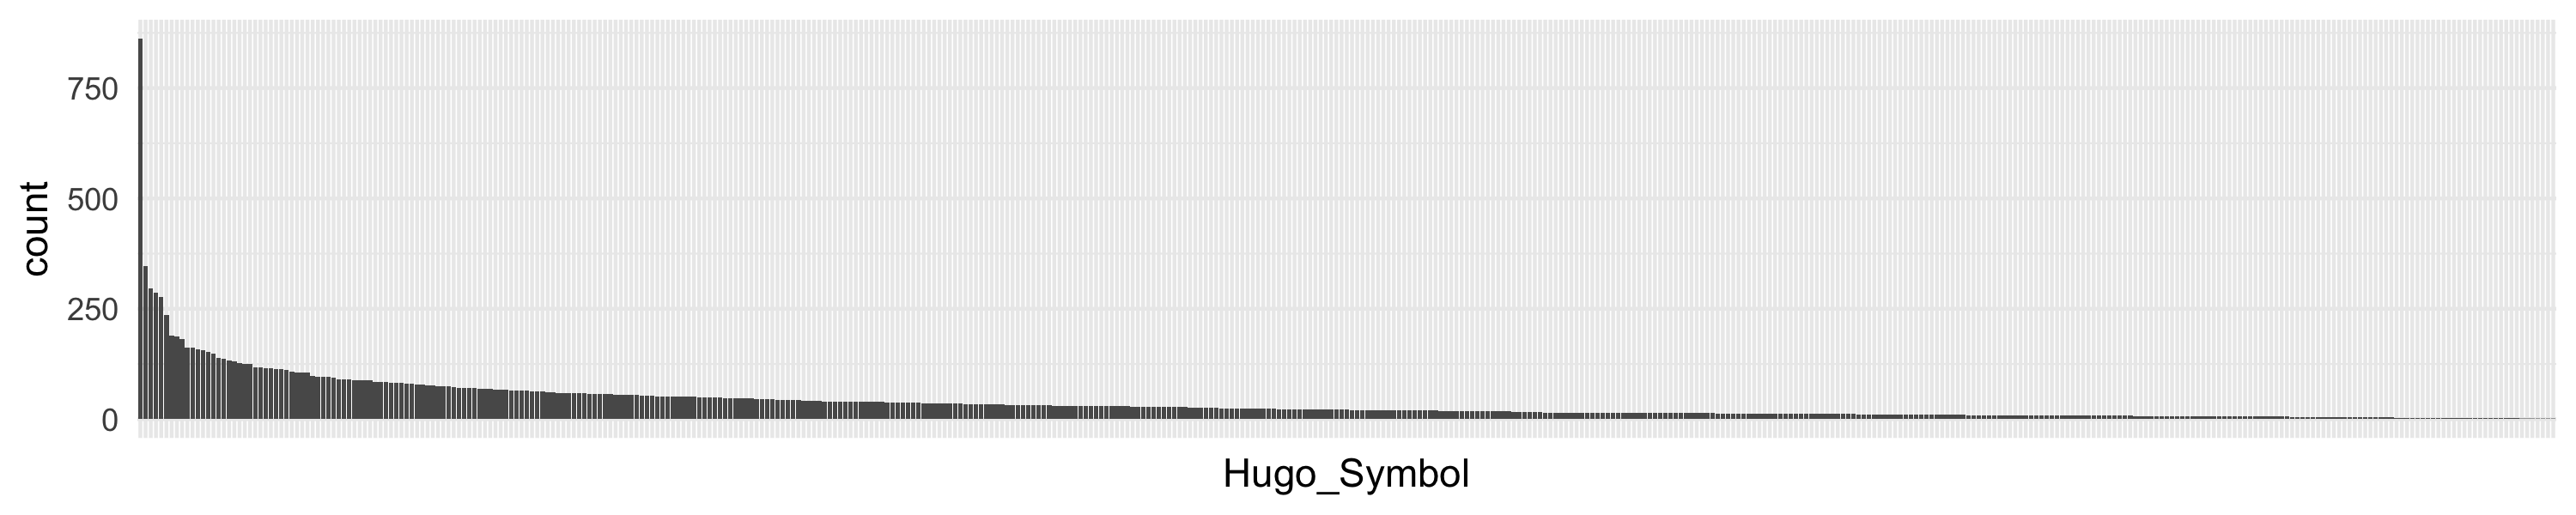

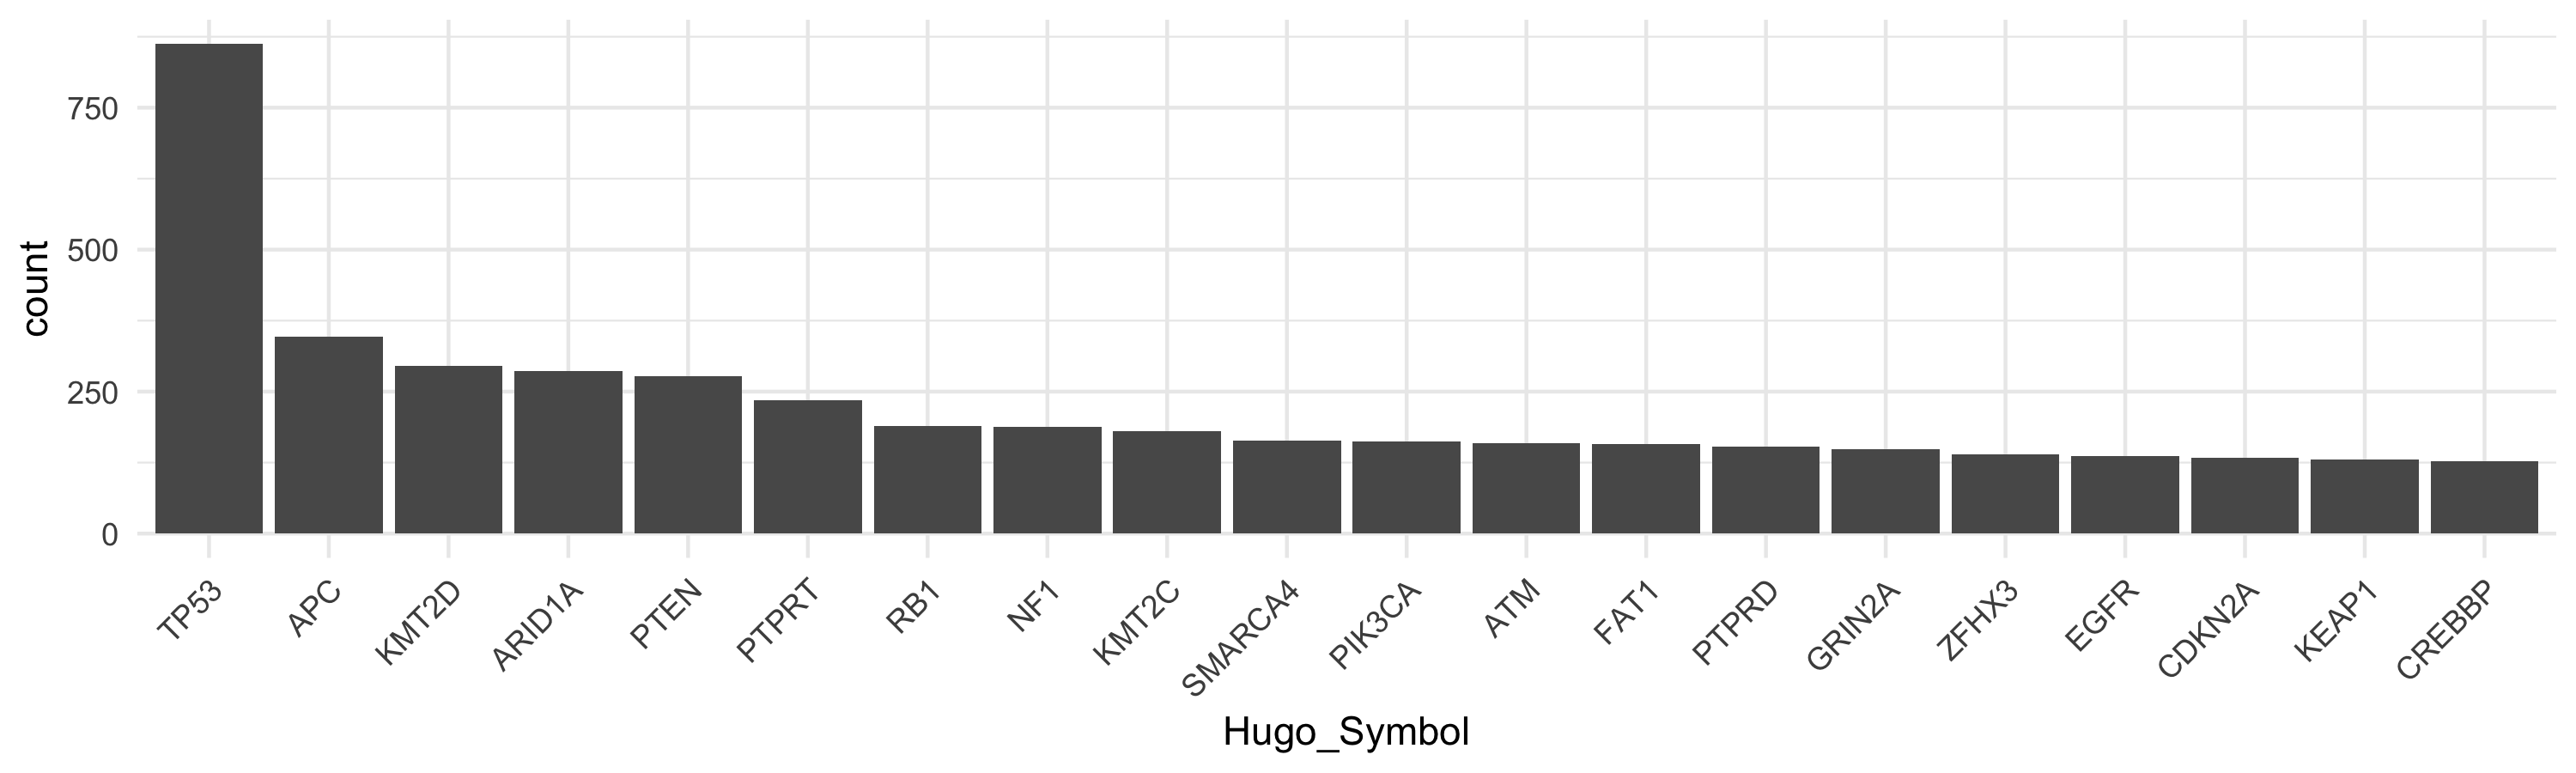

In [27]:
repeated_key <- sort_histogram(repeated_key, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(repeated_key) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(repeated_key, "Hugo_Symbol", 20) + tilt_x_label_45()

Here is a plot of the genes that are the most mutated **accross the rows**:

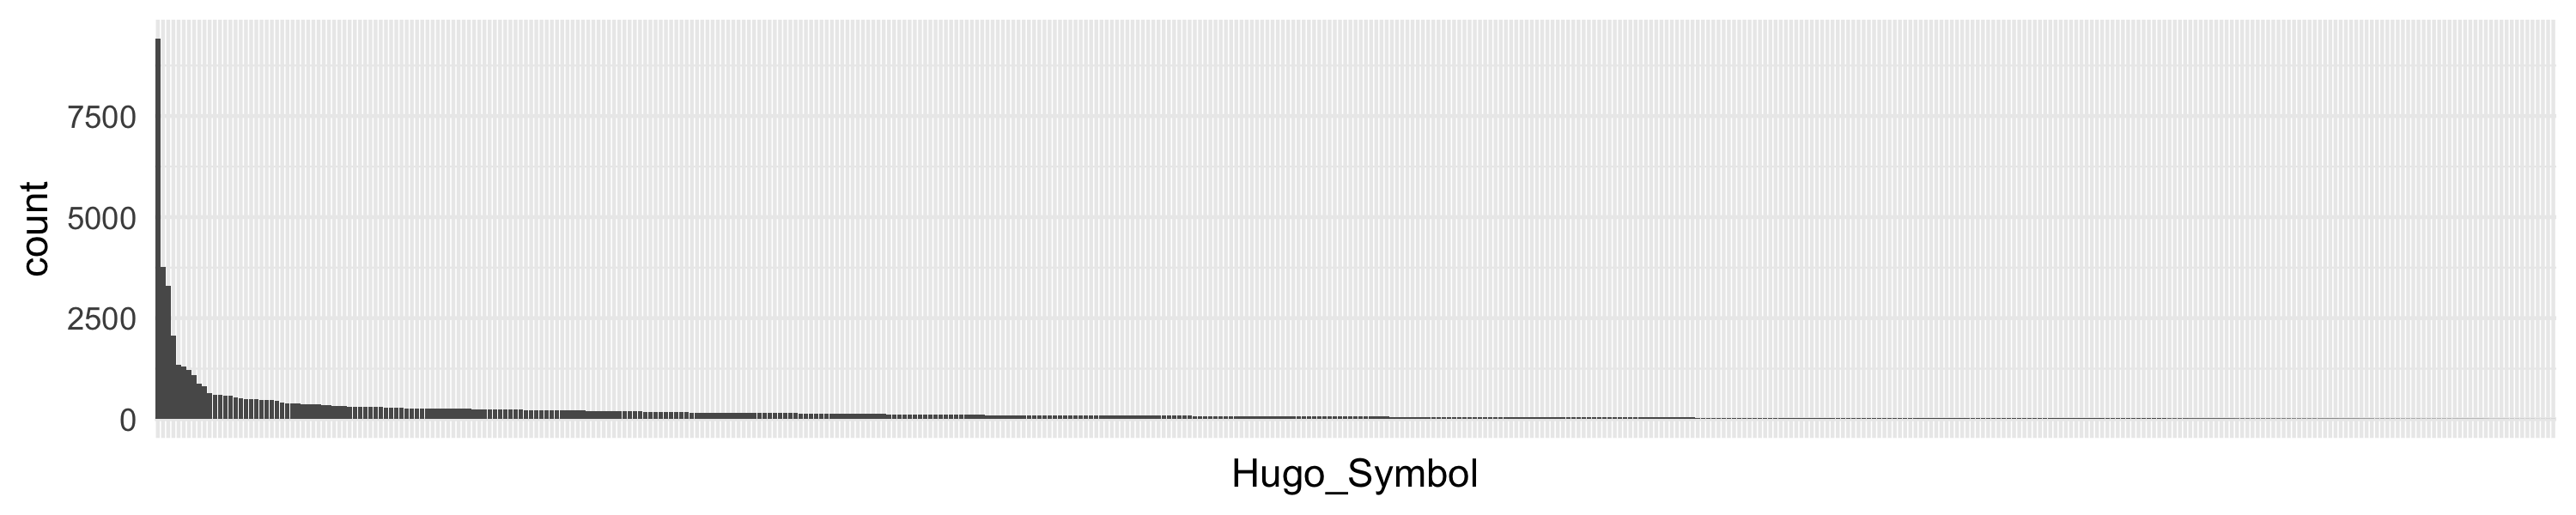

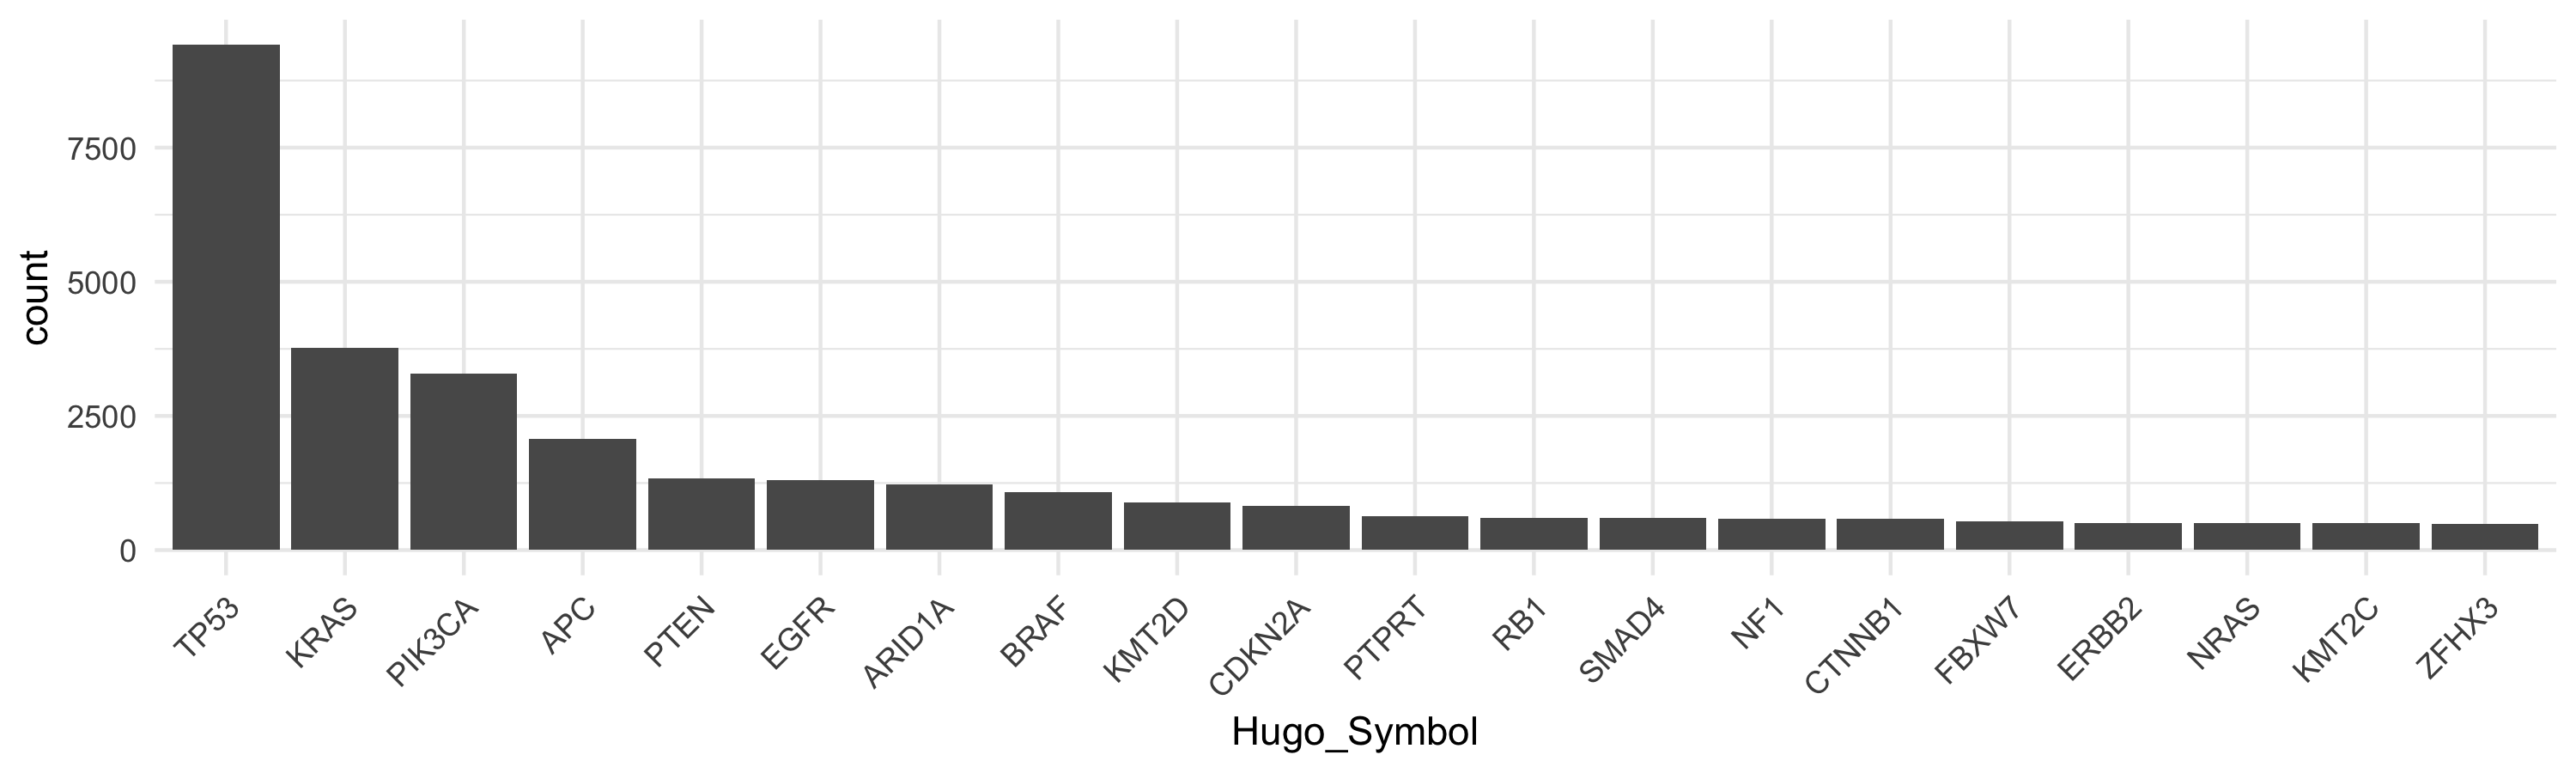

In [28]:
rec_impact <- impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% repeated_key$mut_key,]

rec_impact <- sort_histogram(rec_impact, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(rec_impact) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(rec_impact, "Hugo_Symbol", 20) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

### Study of the proportion of inconsistent features

The mutations sharing the same key should have the same `class`, we evaluate the number of keys and mutations which have different `class` values (e.g the number of mutations classified as `somatic` once and `non-somatic` another time):

In [29]:
keys_inconsistent_class <- impact %>% filter(mut_key %in% repeated_key$mut_key) %>%
                                      group_by(mut_key) %>%
                                      summarise(count = n(),
                                                n_class = length(unique(class)),
                                                n_somatic = sum(class == "somatic"),
                                                n_non_somatic = sum(class == "non-somatic"),
                                                prop_somatic = n_somatic / count,
                                                n_min = min(n_somatic, n_non_somatic),
                                                b = if(min(n_somatic, n_non_somatic) == n_somatic) "somatic" else "non_somatic") %>%
                                      filter(n_class > 1)

sprintf("%.2f%% (%d) keys with inconsistent class ie %.2f%% (%d) of the mutations",
        nrow(keys_inconsistent_class) / length(unique(impact$mut_key)) * 100,
        nrow(keys_inconsistent_class),
        nrow(impact[impact$mut_key %in% keys_inconsistent_class$mut_key,]) / nrow(impact) * 100, 
        nrow(impact[impact$mut_key %in% keys_inconsistent_class$mut_key,]))

[1] "1.07% (1438) keys with inconsistent class ie 9.20% (18244) of the mutations"

In [30]:
table(keys_inconsistent_class$cmin)

Warning message:
“Unknown or uninitialised column: 'cmin'.”

< table of extent 0 >

In [31]:
print_count_and_proportion(nrow(impact[impact$class == "non-somatic" &
                                       impact$mut_key %in% keys_inconsistent_class$mut_key,]),
                           nrow(impact[impact$class == "non-somatic",]))
print_count_and_proportion(nrow(impact[impact$class == "somatic" &
                                       impact$mut_key %in% keys_inconsistent_class$mut_key,]),
                           nrow(impact[impact$class == "somatic",]))

[1] "3312 over 11191 (29.60%)"

[1] "14932 over 187068 (7.98%)"

$9.2\%$ of the rows have a controversed class (29.6% of the `non-somatic` and 7.98% of the `somatic`) ! However, sometimes as we saw during the `cosmic_count` study, we have 100 rows being classified as `somatic` and 2 as `non_somatic`. Suppose we would like to re-label the `class` feature, by re-labelling with the highest class count number (ie in the previous example 2 rows relabeled as `non-somatic`), and let's count the number of rows to re-label:

In [32]:
sprintf("%.2f%% (%d) of the mutations",
        sum(keys_inconsistent_class$n_min) / nrow(impact) * 100,
        sum(keys_inconsistent_class$n_min))

[1] "1.06% (2101) of the mutations"

Now we want to have an idea of the error: among the inconsistent labels is it always 50% somatic and 50% non-somatic, is it mostly somatic and sometimes non-somatic, is it another repartition? The plot below shows the repartition of the proportion of somatic among the inconsistent `keys`:

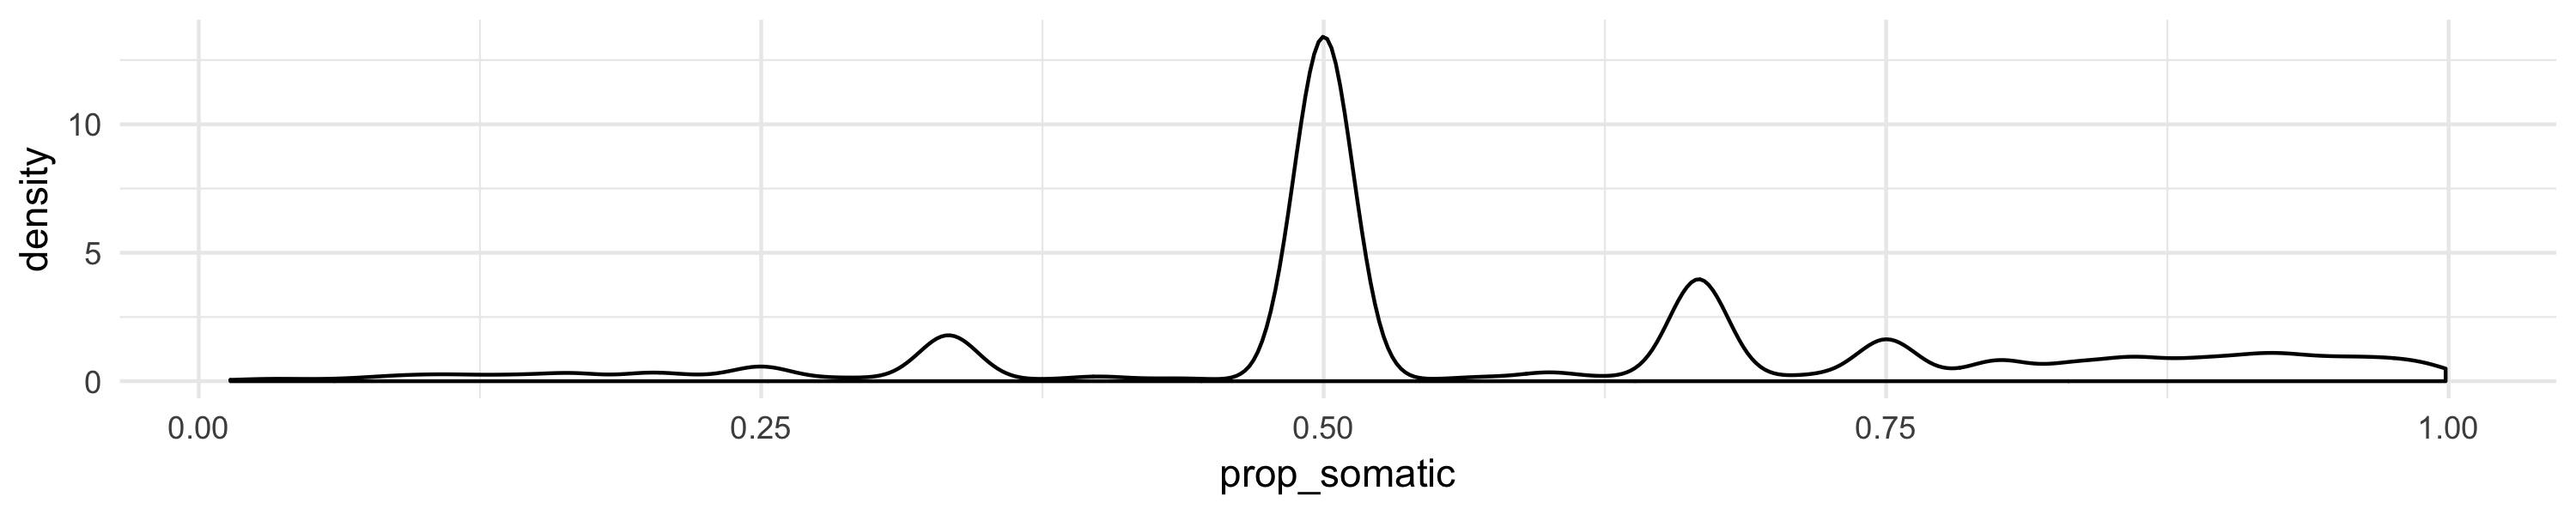

In [33]:
plot_density(keys_inconsistent_class, "prop_somatic", height = 2, adjust = 1/3)

So the errors are more uncertainity than real errors: in most cases, the mutation was equally classified as `somatic` than as `non-somatic`. However, when we study the keys that are shared by more than 5 rows, it seems that most of them are somatic mutations sometimes wrongly classified as `non-somatic`:

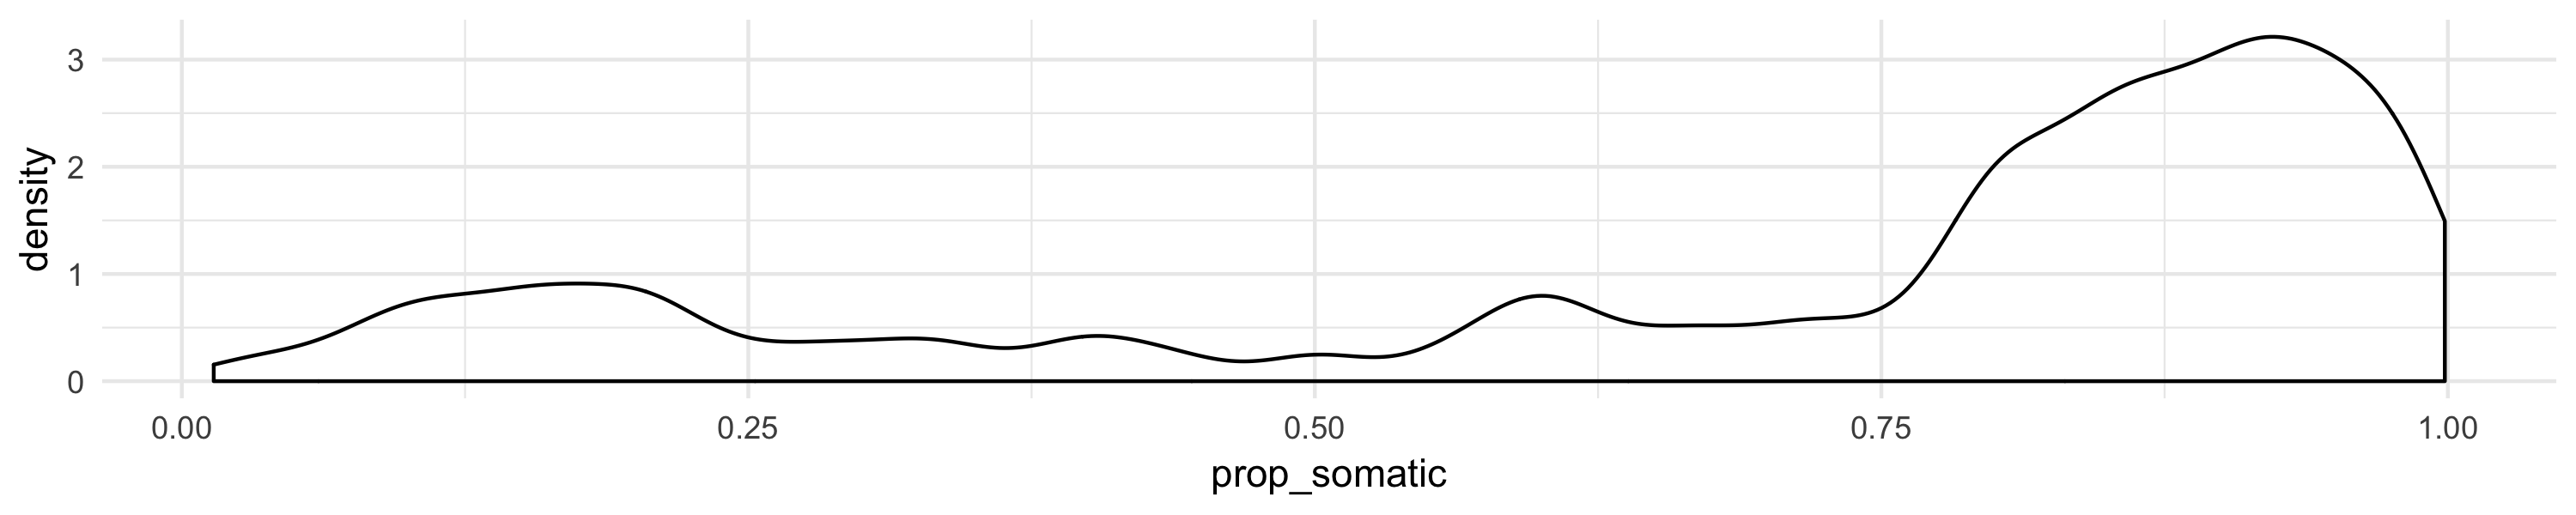

In [34]:
plot_density(keys_inconsistent_class[keys_inconsistent_class$count >= 5,], "prop_somatic", height = 2, adjust = 1/3)

So we have two types of inconsistence:
* keys were we don't know between `somatic` and `non-somatic` (~68%)
* keys that are most of the time `somatic` and sometimes classified as `non-somatic` (~32%)

In [35]:
print_count_and_proportion(nrow(keys_inconsistent_class[keys_inconsistent_class$count >= 5,]),
                           nrow(keys_inconsistent_class))

[1] "462 over 1438 (32.13%)"

In [36]:
expression(paste0("inconsistent ", italic("confidence_class")))

expression(paste0("inconsistent ", italic("confidence_class")))

In [37]:
dd <- impact[impact$mut_key %in% keys_inconsistent_class$mut_key,]
impact$category <- "a"
dd$category <- "b"
dd <- rbind(impact, dd)

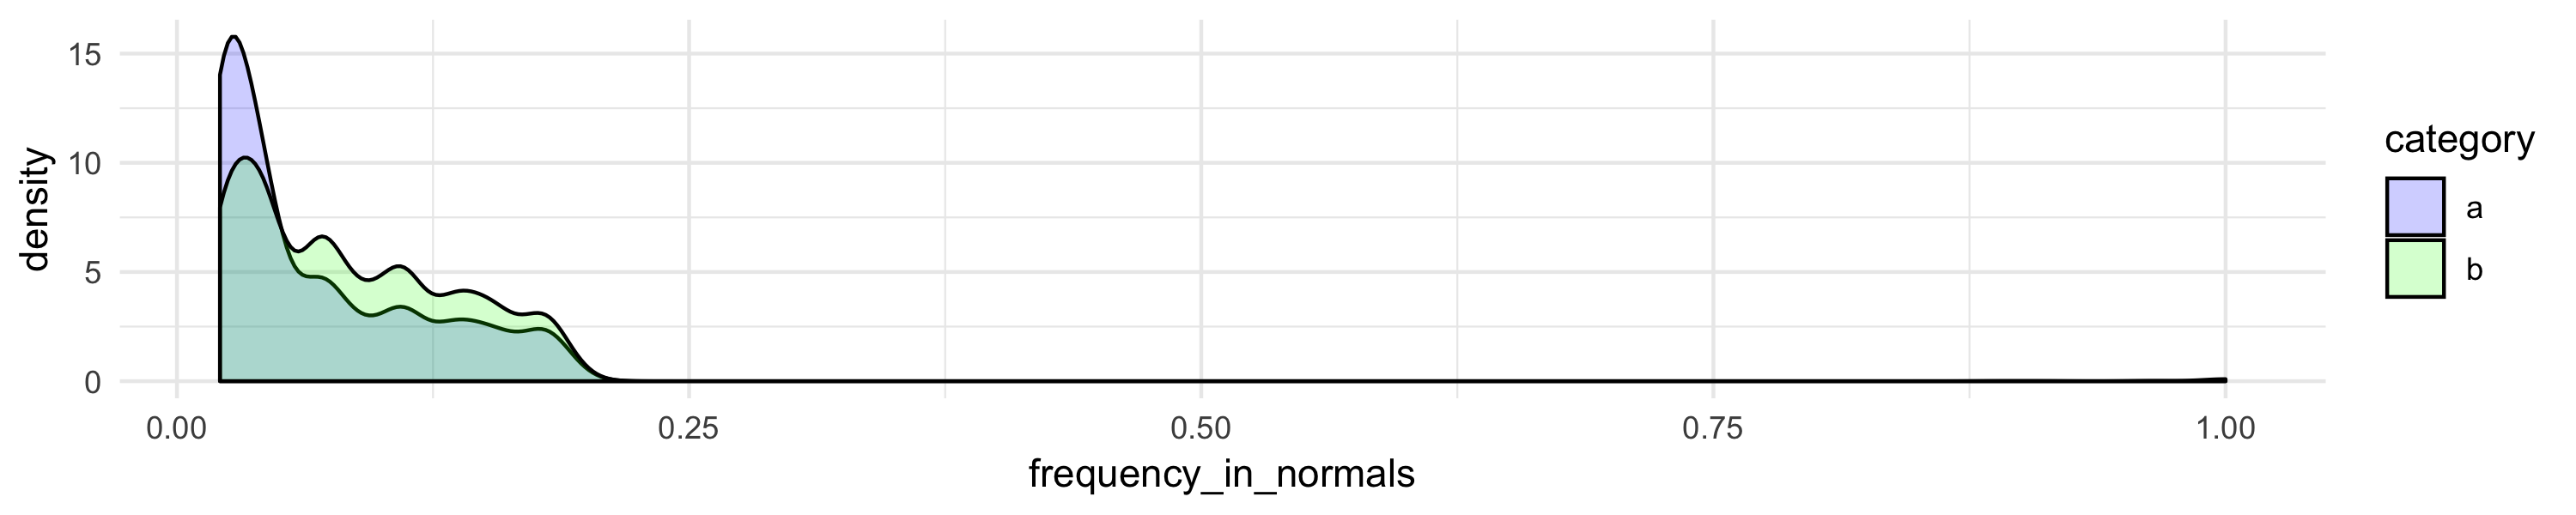

In [38]:
plot_density(dd[dd$frequency_in_normals != 0,], "frequency_in_normals", "category", height = 2)

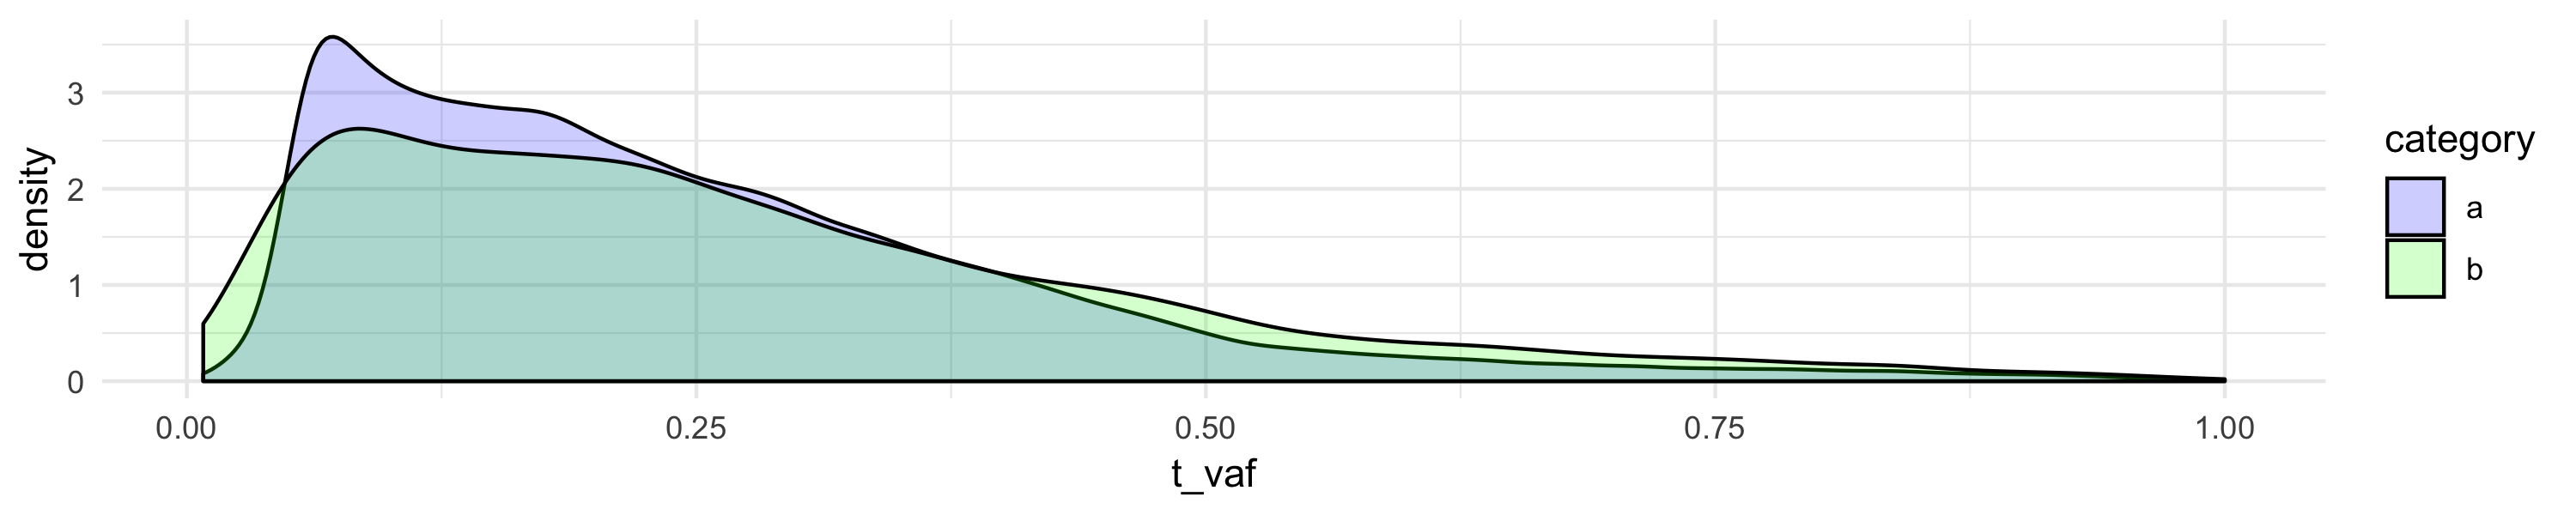

In [39]:
plot_density(dd, "t_vaf", "category", height = 2)

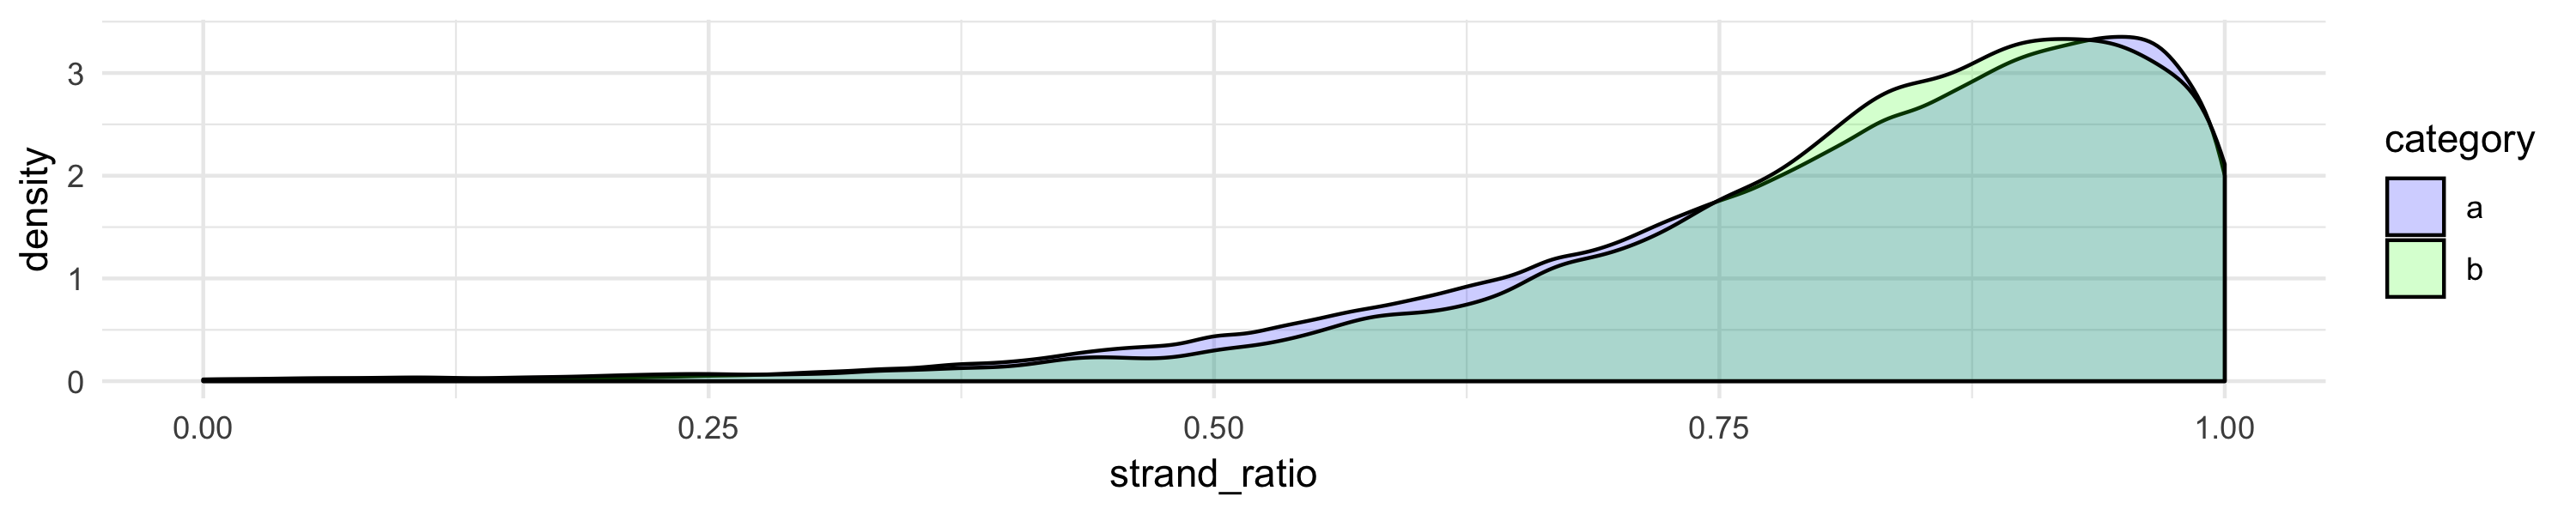

In [40]:
plot_density(dd, "strand_ratio", "category", height = 2)